## Modeling for predicting 72h ED revisit at ED discharge

Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve, get_lstm_data_gen
from dataset_path import output_path

path = output_path

output_path = os.path.join(path, "/sfs/gpfs/tardis/home/rkc7gr/Desktop/MIMIC/mimic4ed-benchmark/data")
if not os.path.exists(output_path):
    os.makedirs(output_path)
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0

2025-05-05 10:29:32.949840: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 10:29:32.955254: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-05 10:29:32.959225: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-05 10:29:32.969029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746455372.986722  406114 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746455372.99

In [2]:
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

index  subject_id     hadm_id   stay_id               intime  \
0  215414    18566742  27103162.0  38538786  2135-07-16 16:08:00   
1  205452    16853729         NaN  30043998  2178-01-25 05:09:00   
2  200705    16026698         NaN  39475313  2128-10-19 20:01:00   
3   87038    15398519  25237915.0  35495155  2147-06-15 09:50:00   
4  373626    16787687  23674090.0  31087259  2181-03-20 10:38:00   

               outtime  anchor_age gender  anchor_year  dod  \
0  2135-07-17 01:49:00          58      F         2132  NaN   
1  2178-01-25 07:05:00          91      F         2169  NaN   
2  2128-10-19 20:16:00          23      M         2128  NaN   
3  2147-06-15 15:55:00          57      M         2136  NaN   
4  2181-03-21 12:55:00          87      F         2176  NaN   

             admittime            dischtime deathtime               ethnicity  \
0  2135-07-17 00:20:00  2135-07-18 18:20:00       NaN         HISPANIC/LATINO   
1                  NaN                  NaN       NaN                   OTHER   
2                  NaN                  NaN       NaN                     NaN   
3  2147-06-15 14:00:00  2147-06-16 16:45:00       NaN  BLACK/AFRICAN AMERICAN   
4  2181-03-20 22:01:00  2181-03-21 12:55:00       NaN  BLACK/AFRICAN AMERICAN   

             edregtime            edouttime insurance  in_year  age  \
0  2135-07-16 16:08:00  2135-07-17 01:49:00     Other     2135   61   
1                  NaN                  NaN       NaN     2178  100   
2                  NaN                  NaN       NaN     2128   23   
3  2147-06-15 09:50:00  2147-06-15 15:55:00  Medicare     2147   68   
4  2181-03-20 10:38:00  2181-03-21 12:55:00  Medicare     2181   92   

   outcome_inhospital_mortality  ed_death  before_ed_mortality  \
0                         False     False                False   
1                         False     False                False   
2                         False     False                False   
3                         False     False                False   
4                         False     False                False   

            ed_los intime_icu time_to_icu_transfer  outcome_icu_transfer_12h  \
0  0 days 09:41:00        NaN                  NaN                     False   
1  0 days 01:56:00        NaN                  NaN                     False   
2  0 days 00:15:00        NaN                  NaN                     False   
3  0 days 06:05:00        NaN                  NaN                     False   
4  1 days 02:17:00        NaN                  NaN                     False   

   outcome_hospitalization  outcome_critical  n_ed_30d  n_ed_90d  n_ed_365d  \
0                     True             False         0         0          0   
1                    False             False         0         1          7   
2                    False             False         0         0          1   
3                     True             False         0         2          5   
4                     True             False         0         0          2   

    next_ed_visit_time next_ed_visit_time_diff  outcome_ed_revisit_3d  \
0  2136-07-30 17:08:00       379 days 15:19:00                  False   
1  2178-03-11 09:43:00        45 days 02:38:00                  False   
2  2129-01-05 21:12:00        78 days 00:56:00                  False   
3  2147-07-01 10:46:00        15 days 18:51:00                  False   
4  2181-04-06 09:43:00        15 days 20:48:00                  False   

   n_hosp_30d  n_hosp_90d  n_hosp_365d  n_icu_30d  n_icu_90d  n_icu_365d  \
0           0           0            0          0          0           0   
1           0           0            5          0          0           0   
2           0           0            0          0          0           0   
3           0           2            5          0          0           1   
4           0           0            2          0          0           0   

   ed_los_hours  time_to_icu_transfer_hours  next_ed_

### 1. task-specific filter: exclude hospitalized cases for train and test

In [4]:
print('Before filtering: training size =', len(df_train), ', testing size =', len(df_test))
df_train = df_train[(df_train['outcome_hospitalization'] == False)]
df_test = df_test[(df_test['outcome_hospitalization'] == False)].reset_index()
print('After filtering: training size =', len(df_train), ', testing size =', len(df_test))

Before filtering: training size = 359043 , testing size = 89761
After filtering: training size = 187418 , testing size = 46951


### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

age  gender n_ed_30d n_ed_90d n_ed_365d n_hosp_30d n_hosp_90d  \
0  int64  object    int64    int64     int64      int64      int64   

  n_hosp_365d n_icu_30d n_icu_90d n_icu_365d triage_pain triage_acuity  \
0       int64     int64     int64      int64     float64       float64   

  chiefcom_chest_pain chiefcom_abdominal_pain chiefcom_headache  \
0                bool                    bool              bool   

  chiefcom_shortness_of_breath chiefcom_back_pain chiefcom_cough  \
0                         bool               bool           bool   

  chiefcom_nausea_vomiting chiefcom_fever_chills chiefcom_syncope  \
0                     bool                  bool             bool   

  chiefcom_dizziness cci_MI cci_CHF cci_PVD cci_Stroke cci_Dementia  \
0               bool  int64   int64   int64      int64        int64   

  cci_Pulmonary cci_Rheumatic cci_PUD cci_Liver1 cci_DM1 cci_DM2  \
0         int64         int64   int64      int64   int64   int64   

  cci_Paralysis cci_Renal cci_Cancer1 cci_Liver2 cci_Cancer2 cci_HIV  \
0         int64     int64       int64      int64       int64   int64   

  eci_Arrhythmia eci_Valvular eci_PHTN eci_HTN1 eci_HTN2 eci_NeuroOther  \
0          int64        int64    int64    int64    int64          int64   

  eci_Hypothyroid eci_Lymphoma eci_Coagulopathy eci_Obesity eci_WeightLoss  \
0           int64        int64            int64       int64          int64   

  eci_FluidsLytes eci_BloodLoss eci_Anemia eci_Alcohol eci_Drugs  \
0           int64         int64      int64       int64     int64   

  eci_Psychoses eci_Depression ed_temperature_last ed_heartrate_last  \
0         int64          int64             float64           float64   

  ed_resprate_last ed_o2sat_last ed_sbp_last ed_dbp_last  ed_los    n_med  \
0          float64       float64     float64     float64  object  float64   

  n_medrecon  
0    float64

In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [10]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.047332185886402756 : 1


### 3.  Modeling script

In [11]:
# Containers for all results
result_list = []

Logistic Regression:


/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 1.4921345710754395 seconds
AUC: 0.6796207376225953
AUPRC: 0.16661975534741724
Sensitivity: 0.5598194130925508
Specificity: 0.6978496065808297
Score thresold: 0.042583961339707446
2.5 97.5


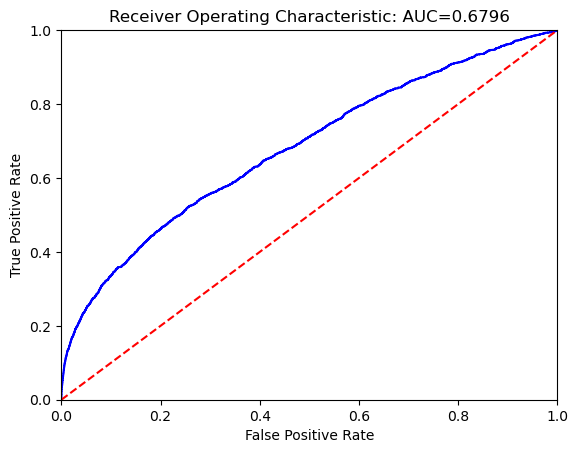

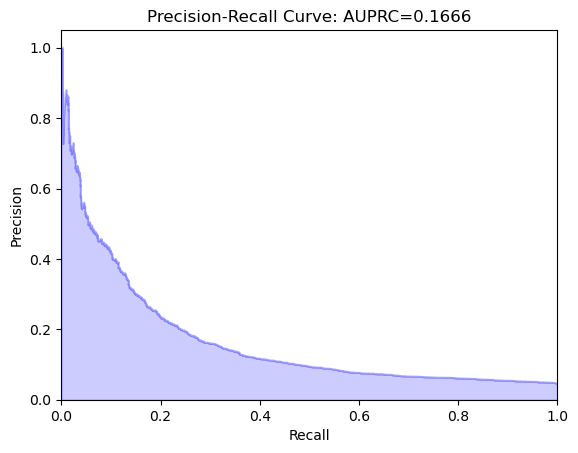

In [13]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



In [14]:
import numpy as np

def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_boot=1000, alpha=0.05, random_seed=42):
    np.random.seed(random_seed)
    boot_vals = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if sensitive_features is not None:
        sensitive_features = np.array(sensitive_features)

    n = len(y_true)
    
    for _ in range(n_boot):
        idx = np.random.choice(n, size=n, replace=True)
        y_true_boot = y_true[idx]
        y_pred_boot = y_pred[idx]
        if sensitive_features is not None:
            sensitive_boot = sensitive_features[idx]
            val = metric_func(y_true_boot, y_pred_boot, sensitive_features=sensitive_boot)
        else:
            val = metric_func(y_true_boot, y_pred_boot)
        boot_vals.append(val)

    mean_val = np.mean(boot_vals)
    lower = np.percentile(boot_vals, 100 * (alpha / 2))
    upper = np.percentile(boot_vals, 100 * (1 - alpha / 2))
    
    return mean_val, (lower, upper)


In [15]:
probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)  # Threshold at 0.5

gender_raw = df_test['gender']

valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]

gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)

print("\n=== Logistic Regression - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Logistic Regression - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===
Accuracy:              Mean = 0.953, CI = (0.951, 0.955)
Demographic Parity:    Mean = 0.007, CI = (0.006, 0.009)
Equal Opportunity:     Mean = 0.070, CI = (0.054, 0.088)
Equalized Odds:        Mean = 0.070, CI = (0.054, 0.088)


In [16]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== Logistic Regression Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Logistic Regression Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.960, CI = (0.957, 0.962)
Selection Rate   Mean = 0.001, CI = (0.001, 0.001)
TPR (Recall)     Mean = 0.012, CI = (0.006, 0.019)
FPR              Mean = 0.001, CI = (0.000, 0.001)

Male:
Accuracy         Mean = 0.944, CI = (0.941, 0.947)
Selection Rate   Mean = 0.008, CI = (0.007, 0.010)
TPR (Recall)     Mean = 0.082, CI = (0.067, 0.098)
FPR              Mean = 0.004, CI = (0.003, 0.005)


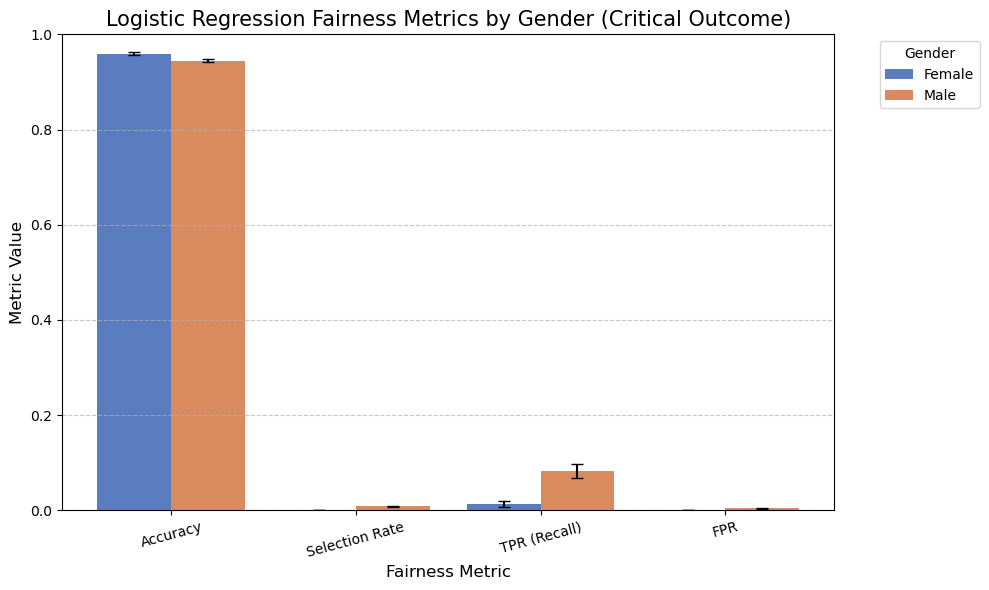

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_logreg_gender_plot = []

for group, metric_dict in metrics.items():
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_logreg_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_logreg_gender_plot = pd.DataFrame(df_logreg_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_logreg_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_logreg_gender_plot['Metric'].unique()
group_list = df_logreg_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_logreg_gender_plot[df_logreg_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Logistic Regression Fairness Metrics by Gender (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [18]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']

valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask]

ethnicity_grouped = ethnicity_clean.str.upper()

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

print("\n=== Logistic Regression - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Logistic Regression - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===
Accuracy:              Mean = 0.909, CI = (0.904, 0.913)
Demographic Parity:    Mean = 0.017, CI = (0.013, 0.020)
Equal Opportunity:     Mean = 0.094, CI = (0.071, 0.120)
Equalized Odds:        Mean = 0.094, CI = (0.071, 0.120)


In [19]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']

valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

ethnicity_metrics = []

for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Logistic Regression - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
for row in ethnicity_metrics:
    print(f"\n Ethnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Logistic Regression - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===

 Ethnicity: White
Accuracy          Mean = 0.900, CI = (0.894, 0.906)
Selection Rate    Mean = 0.012, CI = (0.010, 0.015)
TPR (Recall)      Mean = 0.067, CI = (0.049, 0.086)
FPR               Mean = 0.006, CI = (0.004, 0.008)

 Ethnicity: Black or African American
Accuracy          Mean = 0.913, CI = (0.905, 0.920)
Selection Rate    Mean = 0.017, CI = (0.013, 0.020)
TPR (Recall)      Mean = 0.092, CI = (0.065, 0.121)
FPR               Mean = 0.009, CI = (0.007, 0.012)

 Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.924, CI = (0.912, 0.935)
Selection Rate    Mean = 0.007, CI = (0.004, 0.011)
TPR (Recall)      Mean = 0.062, CI = (0.026, 0.104)
FPR               Mean = 0.002, CI = (0.001, 0.004)

 Ethnicity: Asian
Accuracy          Mean = 0.917, CI = (0.887, 0.943)
Selection Rate    Mean = 0.000, CI = (0.000, 0.000)
TPR (Recall)      Mean = 0.000, CI = (0.000, 0.000)
FPR               Mean

In [22]:
df_test['ethnicity'].value_counts()

#group "ASIAN", "OTHER", and "AMERICAN INDIAN" as "NON-WHITE MINORITIES" 
#to increase sample size for analysis and potentially improve model performance fairness.

ethnicity
WHITE                            8187
BLACK/AFRICAN AMERICAN           4998
HISPANIC/LATINO                  1992
OTHER                             585
ASIAN                             406
AMERICAN INDIAN/ALASKA NATIVE      23
UNKNOWN                            14
Name: count, dtype: int64

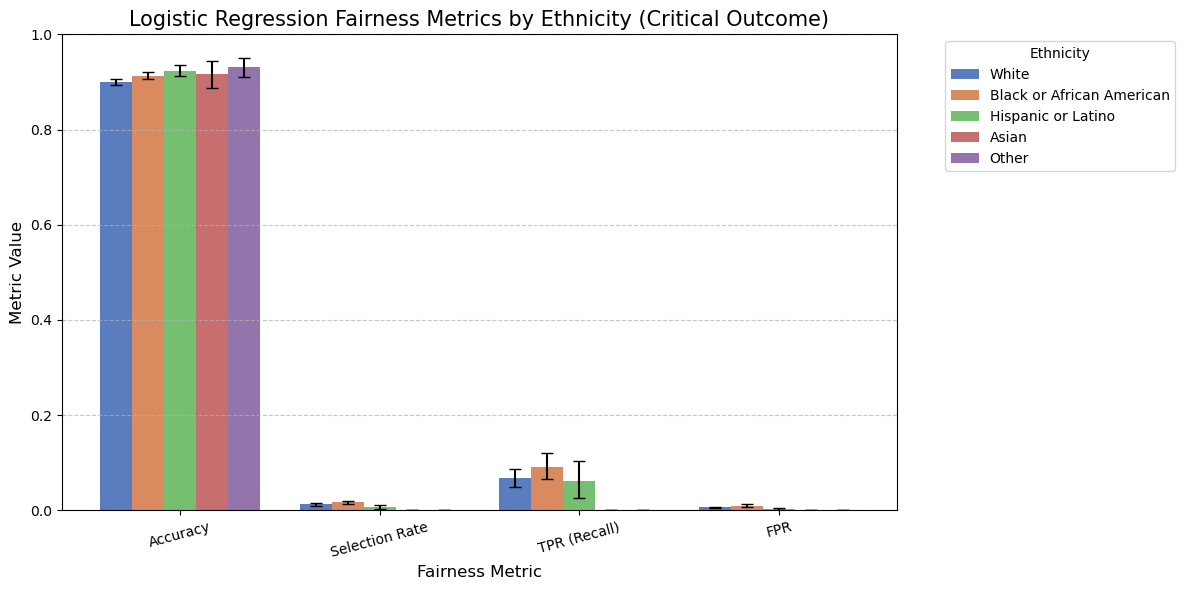

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_logreg_ethnicity_plot = []

for row in ethnicity_metrics:
    group = row['Ethnicity']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']: 
        mean, (ci_low, ci_high) = row[metric_name]
        df_logreg_ethnicity_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_logreg_ethnicity_plot = pd.DataFrame(df_logreg_ethnicity_plot)


plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_logreg_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_logreg_ethnicity_plot['Metric'].unique()
group_list = df_logreg_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_logreg_ethnicity_plot[df_logreg_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Logistic Regression Fairness Metrics by Ethnicity (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [23]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

age_raw = X_test['age']
valid_mask = age_raw.notna()

age_clean = age_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)

print("\n=== Logistic Regression - Bootstrapped Fairness Metrics by Age for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Logistic Regression - Bootstrapped Fairness Metrics by Age for Critical Outcome ===
Accuracy:              Mean = 0.953, CI = (0.951, 0.955)
Demographic Parity:    Mean = 0.034, CI = (0.024, 0.046)
Equal Opportunity:     Mean = 0.378, CI = (0.273, 0.519)
Equalized Odds:        Mean = 0.378, CI = (0.273, 0.519)


In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    metrics = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metric = metric_func(y_true[idx], y_pred[idx])
        metrics.append(metric)

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)

probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)


valid_mask = age_grouped.notna()
y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

group_metrics = []

for group in age_labels:
    group_mask = (age_grouped_clean == group)

    if group_mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, group_mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, group_mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, group_mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, group_mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Logistic Regression - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Logistic Regression - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===

Age Group: 0–17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18–24
Accuracy          Mean = 0.962, CI = (0.958, 0.967)
Selection Rate    Mean = 0.000, CI = (0.000, 0.000)
TPR (Recall)      Mean = 0.000, CI = (0.000, 0.000)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Age Group: 25–34
Accuracy          Mean = 0.956, CI = (0.952, 0.960)
Selection Rate    Mean = 0.001, CI = (0.000, 0.001)
TPR (Recall)      Mean = 0.003, CI = (0.000, 0.008)
FPR               Mean = 0.001, CI = (0.000, 0.001)

Age Group: 35–44
Accuracy          Mean = 0.956, CI = (0.951, 0.961)
Selection Rate    Mean = 0.001, CI = (0.000, 0.002)
TPR (Recall)      Mean = 0.016, CI = (0.003, 0.032)
FPR               Mean = 0.001, CI = (0.000, 0.001)

Age Group: 45–54
Accuracy          Mean = 0.952, CI = (0.9

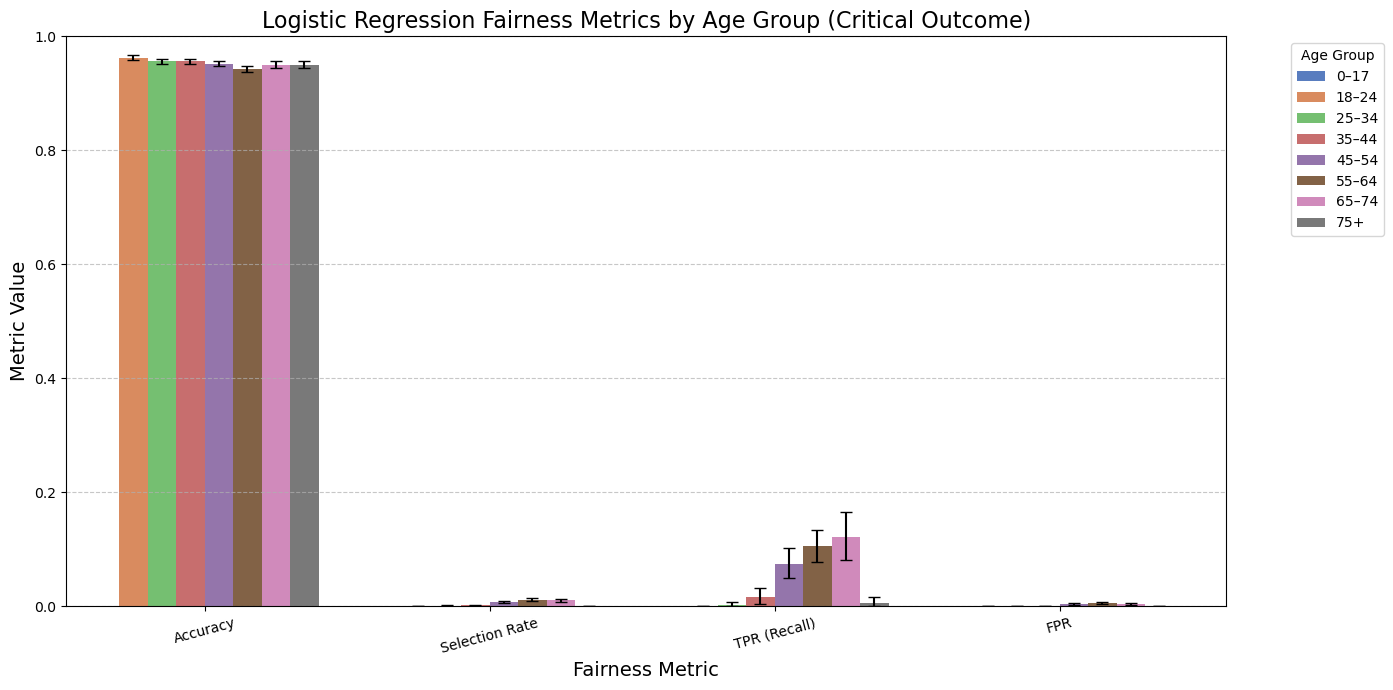

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df_logreg_age_plot = []

for row in group_metrics:
    group = row['Age Group']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_logreg_age_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_logreg_age_plot = pd.DataFrame(df_logreg_age_plot)

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_logreg_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_logreg_age_plot['Metric'].unique()
group_list = df_logreg_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_logreg_age_plot[df_logreg_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('Logistic Regression Fairness Metrics by Age Group (Critical Outcome)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [38]:
print(insurance_grouped.value_counts())



Series([], Name: count, dtype: int64)


In [39]:
pd.crosstab(insurance_grouped, y_pred_clean)


Empty DataFrame
Columns: []
Index: []

In [40]:
print(df_test['insurance'].unique())


[nan]


In [42]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import accuracy_score
# from fairlearn.metrics import (
#     demographic_parity_difference,
#     equal_opportunity_difference,
#     equalized_odds_difference
# )

# probs = logreg.predict_proba(X_test)
# y_pred = (probs[:, 1] >= 0.5).astype(int)


# insurance_raw = df_test['insurance']

# valid_mask = (
#     insurance_raw.notna() &
#     (insurance_raw != '') &
#     (insurance_raw.str.lower() != 'unknown')
# )

# insurance_clean = insurance_raw[valid_mask]
# y_test_clean = y_test[valid_mask]
# y_pred_clean = y_pred[valid_mask]

# insurance_grouped = insurance_clean.str.lower().map({
#     'medicaid': 'Medicaid',
#     'medicare': 'Medicare'
# }).fillna('Other')

# acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
# dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped)
# eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped)
# eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped)

# print("\n=== Logistic Regression - Bootstrapped Fairness & Accuracy Metrics by Insurance for Critical Outcome ===")
# print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
# print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
# print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
# print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")


In [43]:
# All bootstrap iterations failed or were skipped. Returning NaNs.

# === Logistic Regression - Bootstrapped Fairness & Accuracy Metrics by Insurance for Critical Outcome ===
# Accuracy:              Mean = nan, CI = (nan, nan)
# Demographic Parity:    Mean = nan, CI = (nan, nan)
# Equal Opportunity:     Mean = nan, CI = (nan, nan)
# Equalized Odds:        Mean = nan, CI = (nan, nan)

RandomForest:
Training time: 32.99796485900879 seconds
AUC: 0.6646374759007547
AUPRC: 0.15565265447630927
Sensitivity: 0.6058690744920994
Specificity: 0.6243517525035766
Score thresold: 0.05
2.5 97.5


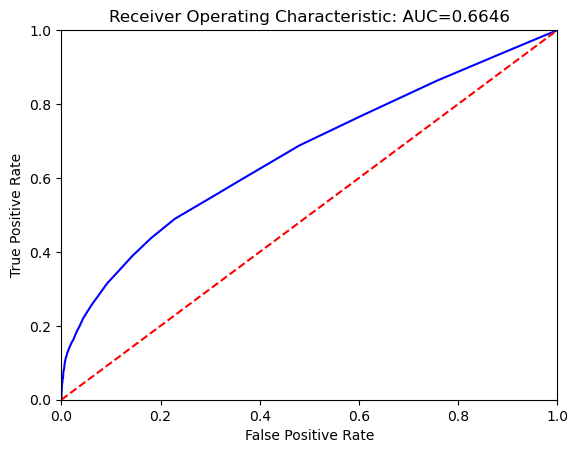

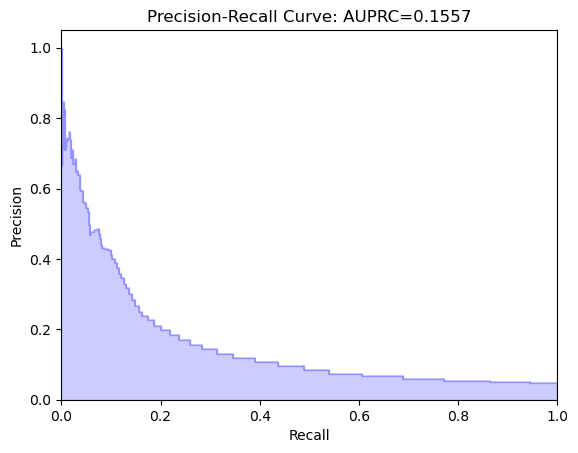

[0.08415979 0.01460333 0.02050198 0.02465317 0.0332894  0.00933872
 0.01247868 0.02057943 0.00106761 0.00210073 0.00429974 0.04463925
 0.02304584 0.00507323 0.00869105 0.00567274 0.00027781 0.00581566
 0.00228    0.00409244 0.00327748 0.00192442 0.00326276 0.00287789
 0.00291341 0.00253755 0.00283962 0.00135657 0.00599057 0.00194569
 0.00165844 0.00402879 0.00515745 0.00276473 0.00135181 0.00278592
 0.00311716 0.00153085 0.00169816 0.00162146 0.00501133 0.00228337
 0.00232342 0.00273394 0.00621957 0.00454111 0.00365139 0.00103915
 0.00353462 0.00467922 0.00298323 0.00509806 0.00136061 0.00373267
 0.0053283  0.00530189 0.0034033  0.00628087 0.06712812 0.07626625
 0.03756881 0.04015678 0.07889443 0.07592328 0.08387365 0.03948221
 0.04989911]


In [44]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [48]:
probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

In [49]:
import numpy as np

def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_boot=1000, alpha=0.05, random_seed=42):
    np.random.seed(random_seed)
    values = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if sensitive_features is not None:
        sensitive_features = np.array(sensitive_features)

    n = len(y_true)

    for _ in range(n_boot):
        idx = np.random.choice(n, size=n, replace=True)
        y_true_boot = y_true[idx]
        y_pred_boot = y_pred[idx]
        if sensitive_features is not None:
            sf_boot = sensitive_features[idx]
            val = metric_func(y_true_boot, y_pred_boot, sensitive_features=sf_boot)
        else:
            val = metric_func(y_true_boot, y_pred_boot)
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))

    return mean_val, (ci_lower, ci_upper)


In [50]:
gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)

metrics_summary = {
    "Accuracy": (acc_mean, acc_ci),
    "Demographic Parity": (dpd_mean, dpd_ci),
    "Equal Opportunity": (eopp_mean, eopp_ci),
    "Equalized Odds": (eod_mean, eod_ci)
}

print("\n=== Random Forest - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===")
for name, (mean, (ci_low, ci_high)) in metrics_summary.items():
    print(f"{name:<22} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Random Forest - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===
Accuracy               Mean = 0.953, CI = (0.952, 0.955)
Demographic Parity     Mean = 0.005, CI = (0.004, 0.007)
Equal Opportunity      Mean = 0.054, CI = (0.039, 0.071)
Equalized Odds         Mean = 0.054, CI = (0.039, 0.071)


In [51]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== Random Forest Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Random Forest Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.960, CI = (0.958, 0.962)
Selection Rate   Mean = 0.001, CI = (0.000, 0.001)
TPR (Recall)     Mean = 0.012, CI = (0.006, 0.019)
FPR              Mean = 0.000, CI = (0.000, 0.001)

Male:
Accuracy         Mean = 0.945, CI = (0.941, 0.948)
Selection Rate   Mean = 0.006, CI = (0.005, 0.007)
TPR (Recall)     Mean = 0.066, CI = (0.052, 0.081)
FPR              Mean = 0.003, CI = (0.002, 0.003)


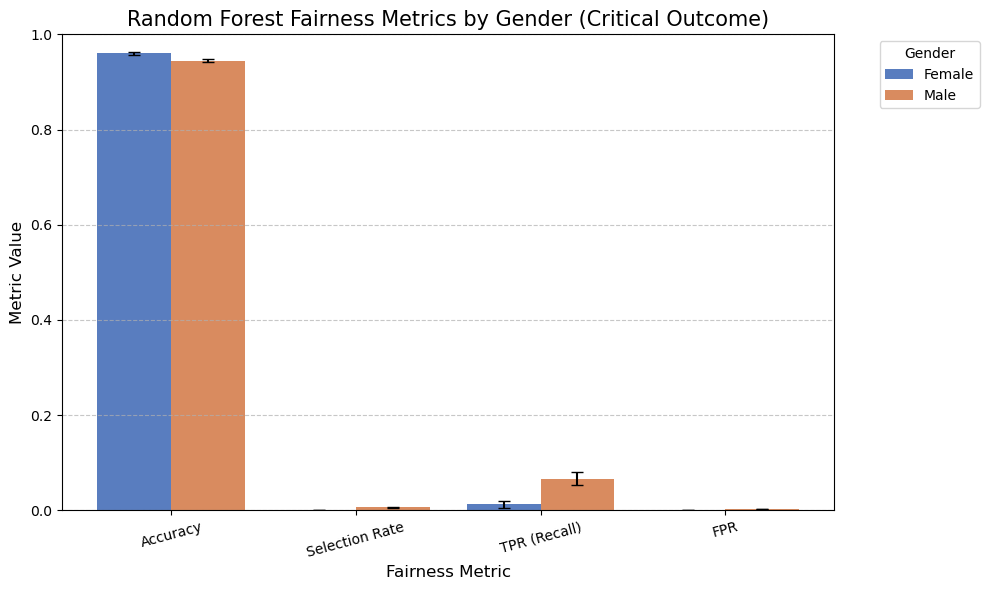

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_rf_gender_plot = []

for group, metric_dict in metrics.items(): 
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_rf_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_rf_gender_plot = pd.DataFrame(df_rf_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_rf_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_rf_gender_plot['Metric'].unique()
group_list = df_rf_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_rf_gender_plot[df_rf_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Random Forest Fairness Metrics by Gender (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [53]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']

valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask]

ethnicity_grouped = ethnicity_clean.str.upper()

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

print("\n=== Random Forest - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Random Forest - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===
Accuracy:              Mean = 0.910, CI = (0.905, 0.914)
Demographic Parity:    Mean = 0.011, CI = (0.009, 0.013)
Equal Opportunity:     Mean = 0.070, CI = (0.055, 0.087)
Equalized Odds:        Mean = 0.070, CI = (0.055, 0.087)


In [54]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']
valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

ethnicity_metrics = []

for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Random Forest - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
for row in ethnicity_metrics:
    print(f"\n Ethnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Random Forest - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===

 Ethnicity: White
Accuracy          Mean = 0.901, CI = (0.895, 0.907)
Selection Rate    Mean = 0.011, CI = (0.009, 0.013)
TPR (Recall)      Mean = 0.066, CI = (0.050, 0.085)
FPR               Mean = 0.005, CI = (0.003, 0.006)

 Ethnicity: Black or African American
Accuracy          Mean = 0.914, CI = (0.907, 0.922)
Selection Rate    Mean = 0.009, CI = (0.007, 0.012)
TPR (Recall)      Mean = 0.060, CI = (0.039, 0.083)
FPR               Mean = 0.004, CI = (0.003, 0.006)

 Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.923, CI = (0.912, 0.935)
Selection Rate    Mean = 0.004, CI = (0.002, 0.008)
TPR (Recall)      Mean = 0.044, CI = (0.013, 0.080)
FPR               Mean = 0.001, CI = (0.000, 0.003)

 Ethnicity: Asian
Accuracy          Mean = 0.917, CI = (0.887, 0.943)
Selection Rate    Mean = 0.000, CI = (0.000, 0.000)
TPR (Recall)      Mean = 0.000, CI = (0.000, 0.000)
FPR               Mean = 0.0

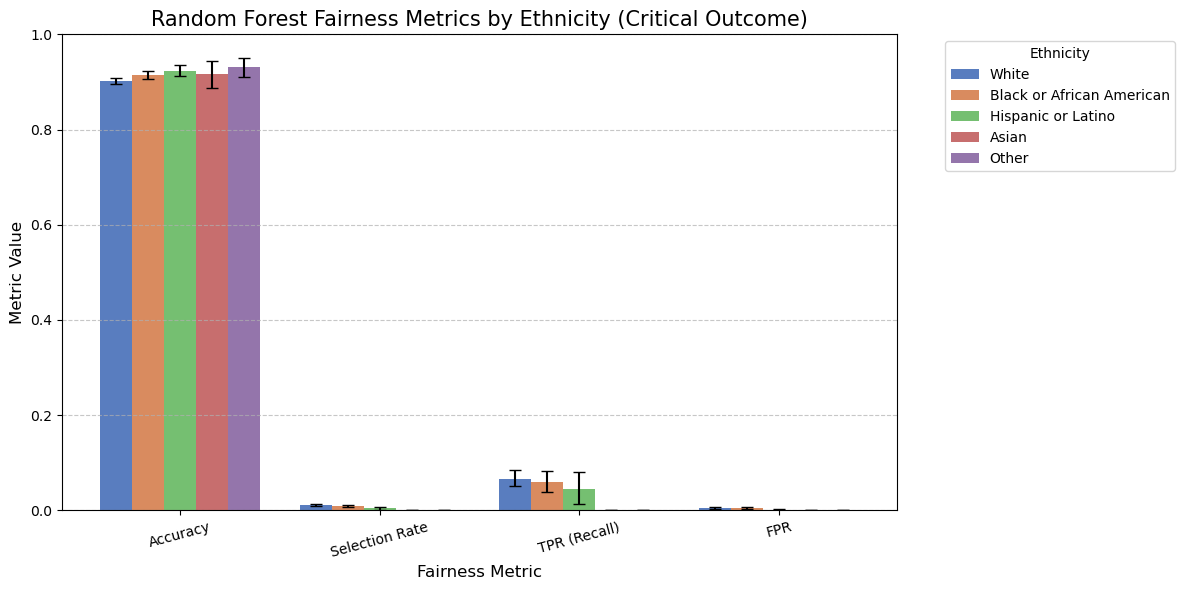

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_rf_ethnicity_plot = []

for row in ethnicity_metrics:
    group = row['Ethnicity']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']: 
        mean, (ci_low, ci_high) = row[metric_name]
        df_rf_ethnicity_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_rf_ethnicity_plot = pd.DataFrame(df_rf_ethnicity_plot)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_rf_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_rf_ethnicity_plot['Metric'].unique()
group_list = df_rf_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_rf_ethnicity_plot[df_rf_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Random Forest Fairness Metrics by Ethnicity (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [56]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

age_raw = X_test['age']
valid_mask = age_raw.notna()

age_clean = age_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)

print("\n=== Random Forest - Bootstrapped Fairness Metrics by Age for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Random Forest - Bootstrapped Fairness Metrics by Age for Critical Outcome ===
Accuracy:              Mean = 0.953, CI = (0.952, 0.955)
Demographic Parity:    Mean = 0.036, CI = (0.025, 0.050)
Equal Opportunity:     Mean = 0.363, CI = (0.258, 0.515)
Equalized Odds:        Mean = 0.363, CI = (0.258, 0.515)


In [57]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    metrics = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metric = metric_func(y_true[idx], y_pred[idx])
        metrics.append(metric)

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)

probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)

valid_mask = age_grouped.notna()
y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

group_metrics = []

for group in age_labels:
    group_mask = (age_grouped_clean == group)

    if group_mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, group_mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, group_mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, group_mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, group_mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Random Forest - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Random Forest - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===

Age Group: 0–17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18–24
Accuracy          Mean = 0.962, CI = (0.958, 0.967)
Selection Rate    Mean = 0.000, CI = (0.000, 0.000)
TPR (Recall)      Mean = 0.000, CI = (0.000, 0.000)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Age Group: 25–34
Accuracy          Mean = 0.956, CI = (0.952, 0.960)
Selection Rate    Mean = 0.000, CI = (0.000, 0.001)
TPR (Recall)      Mean = 0.002, CI = (0.000, 0.008)
FPR               Mean = 0.000, CI = (0.000, 0.001)

Age Group: 35–44
Accuracy          Mean = 0.956, CI = (0.951, 0.961)
Selection Rate    Mean = 0.002, CI = (0.001, 0.002)
TPR (Recall)      Mean = 0.023, CI = (0.009, 0.040)
FPR               Mean = 0.001, CI = (0.000, 0.001)

Age Group: 45–54
Accuracy          Mean = 0.953, CI = (0.948, 0.

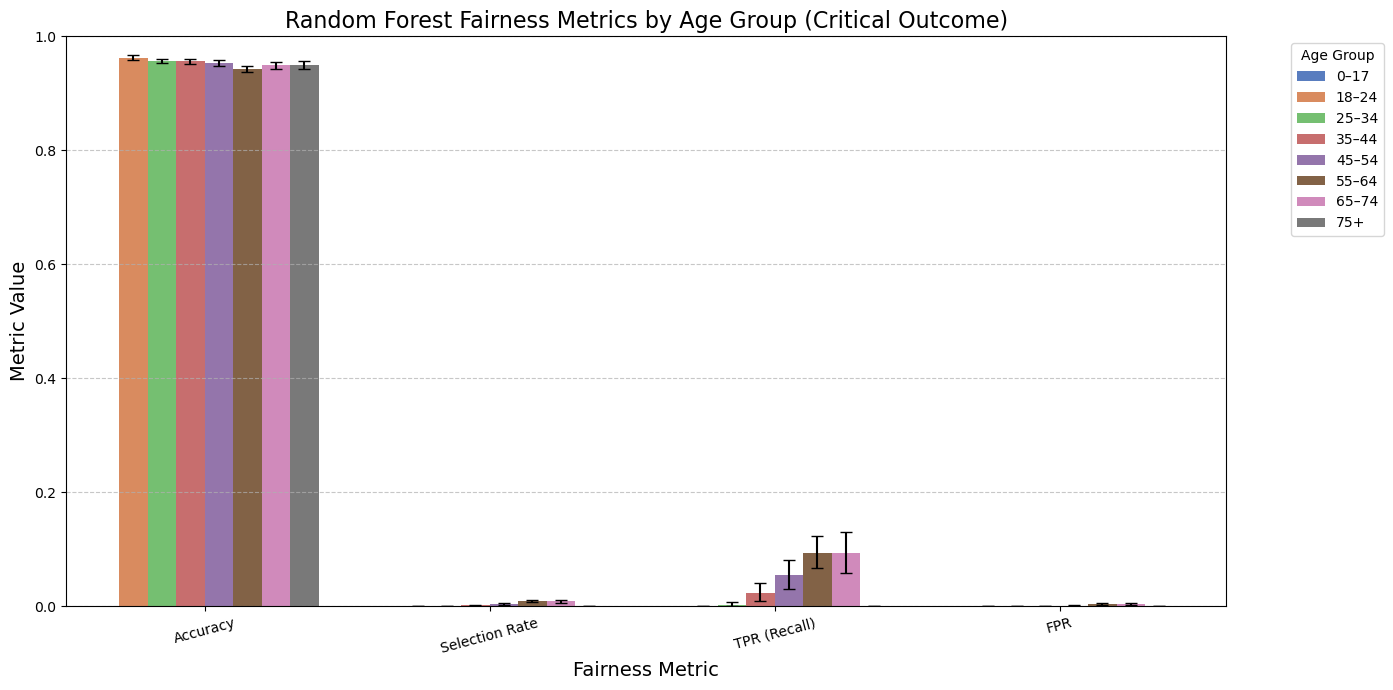

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df_rf_age_plot = []

for row in group_metrics:
    group = row['Age Group']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_rf_age_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_rf_age_plot = pd.DataFrame(df_rf_age_plot)

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_rf_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_rf_age_plot['Metric'].unique()
group_list = df_rf_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_rf_age_plot[df_rf_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width / 2 + j * group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('Random Forest Fairness Metrics by Age Group (Critical Outcome)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


GradientBoosting:
Training time: 32.77081871032715 seconds
AUC: 0.6956175653626432
AUPRC: 0.17315201453158413
Sensitivity: 0.5873589164785553
Specificity: 0.6903388769670958
Score thresold: 0.04020764428743694
2.5 97.5


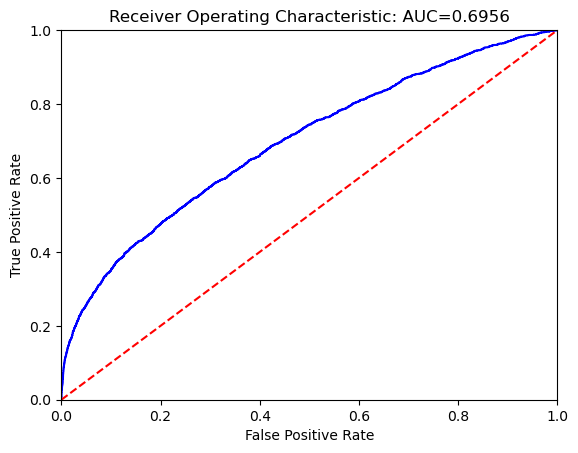

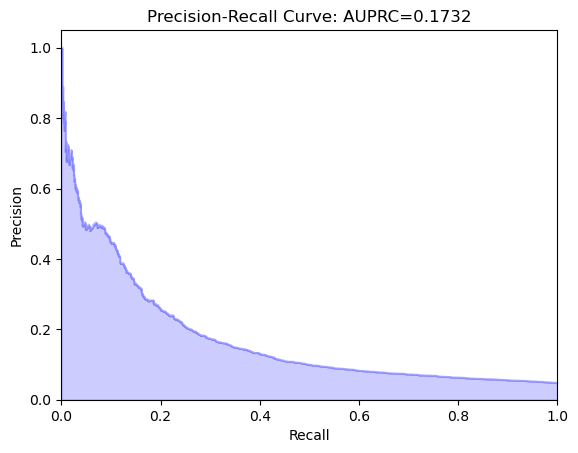

In [60]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [61]:
probs = gb.predict_proba(X_test)  
y_pred = (probs[:, 1] >= 0.5).astype(int)

In [62]:

import numpy as np

def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_boot=1000, alpha=0.05, random_seed=42):
    np.random.seed(random_seed)
    values = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if sensitive_features is not None:
        sensitive_features = np.array(sensitive_features)

    n = len(y_true)

    for _ in range(n_boot):
        idx = np.random.choice(n, size=n, replace=True)
        y_true_boot = y_true[idx]
        y_pred_boot = y_pred[idx]
        if sensitive_features is not None:
            sf_boot = sensitive_features[idx]
            val = metric_func(y_true_boot, y_pred_boot, sensitive_features=sf_boot)
        else:
            val = metric_func(y_true_boot, y_pred_boot)
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))

    return mean_val, (ci_lower, ci_upper)

In [65]:
gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)

metrics_summary = {
    "Accuracy": (acc_mean, acc_ci),
    "Demographic Parity": (dpd_mean, dpd_ci),
    "Equal Opportunity": (eopp_mean, eopp_ci),
    "Equalized Odds": (eod_mean, eod_ci)
}

print("\n=== Gradient Boosting - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===")
for name, (mean, (ci_low, ci_high)) in metrics_summary.items():
    print(f"{name:<22} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===
Accuracy               Mean = 0.953, CI = (0.951, 0.955)
Demographic Parity     Mean = 0.005, CI = (0.004, 0.006)
Equal Opportunity      Mean = 0.047, CI = (0.032, 0.063)
Equalized Odds         Mean = 0.047, CI = (0.032, 0.063)


In [66]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

probs = gb.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== Gradient Boosting Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.960, CI = (0.958, 0.962)
Selection Rate   Mean = 0.001, CI = (0.001, 0.001)
TPR (Recall)     Mean = 0.014, CI = (0.007, 0.022)
FPR              Mean = 0.000, CI = (0.000, 0.001)

Male:
Accuracy         Mean = 0.944, CI = (0.941, 0.947)
Selection Rate   Mean = 0.006, CI = (0.005, 0.007)
TPR (Recall)     Mean = 0.061, CI = (0.048, 0.075)
FPR              Mean = 0.003, CI = (0.002, 0.004)


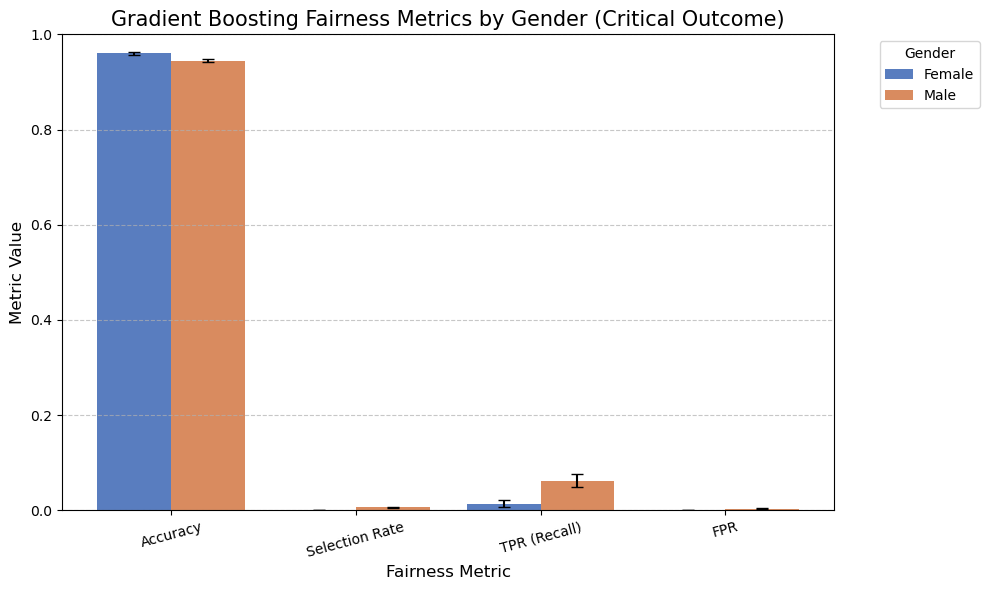

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_gb_gender_plot = []

for group, metric_dict in metrics.items(): 
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_gb_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_gb_gender_plot = pd.DataFrame(df_gb_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_gb_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_gb_gender_plot['Metric'].unique()
group_list = df_gb_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_gb_gender_plot[df_gb_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Gradient Boosting Fairness Metrics by Gender (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [68]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = gb.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']

valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask]

ethnicity_grouped = ethnicity_clean.str.upper()

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

print("\n=== Gradient Boosting - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Gradient Boosting - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===
Accuracy:              Mean = 0.909, CI = (0.904, 0.913)
Demographic Parity:    Mean = 0.011, CI = (0.009, 0.014)
Equal Opportunity:     Mean = 0.070, CI = (0.054, 0.091)
Equalized Odds:        Mean = 0.070, CI = (0.054, 0.091)


In [69]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0


def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

probs = gb.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']
valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

ethnicity_metrics = []

for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Gradient Boosting - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
for row in ethnicity_metrics:
    print(f"\n Ethnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===

 Ethnicity: White
Accuracy          Mean = 0.900, CI = (0.894, 0.906)
Selection Rate    Mean = 0.011, CI = (0.009, 0.013)
TPR (Recall)      Mean = 0.059, CI = (0.044, 0.076)
FPR               Mean = 0.005, CI = (0.004, 0.007)

 Ethnicity: Black or African American
Accuracy          Mean = 0.914, CI = (0.907, 0.922)
Selection Rate    Mean = 0.011, CI = (0.008, 0.014)
TPR (Recall)      Mean = 0.067, CI = (0.045, 0.090)
FPR               Mean = 0.006, CI = (0.004, 0.008)

 Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.923, CI = (0.911, 0.935)
Selection Rate    Mean = 0.004, CI = (0.002, 0.007)
TPR (Recall)      Mean = 0.038, CI = (0.012, 0.071)
FPR               Mean = 0.001, CI = (0.000, 0.003)

 Ethnicity: Asian
Accuracy          Mean = 0.917, CI = (0.887, 0.943)
Selection Rate    Mean = 0.000, CI = (0.000, 0.000)
TPR (Recall)      Mean = 0.000, CI = (0.000, 0.000)
FPR               Mean =

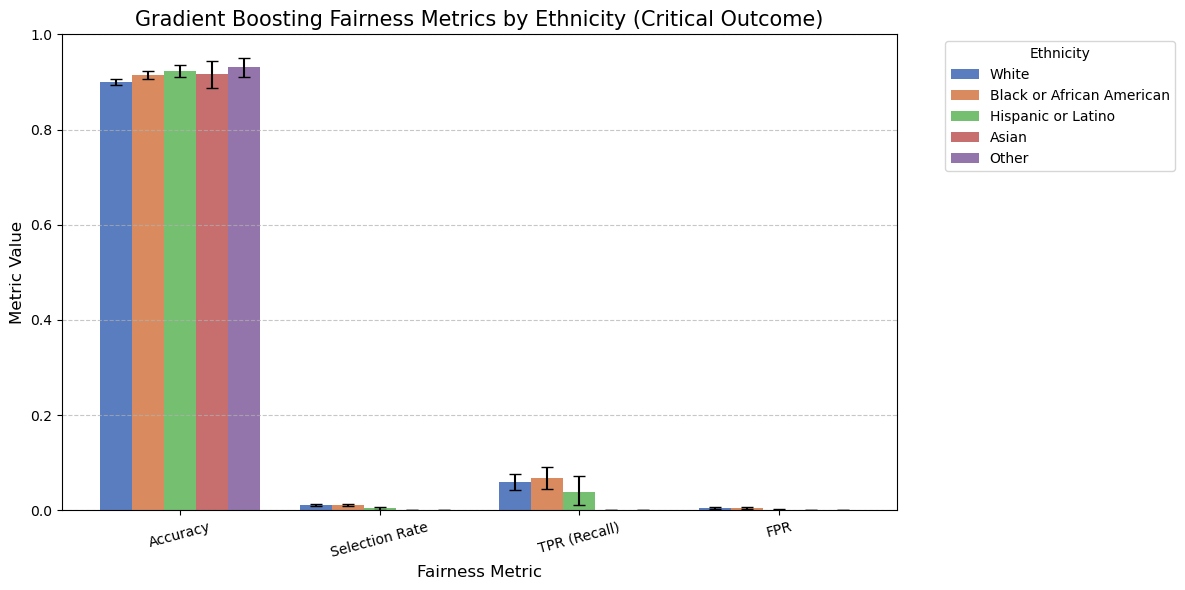

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_gb_ethnicity_plot = []

for row in ethnicity_metrics:
    group = row['Ethnicity']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']: 
        mean, (ci_low, ci_high) = row[metric_name]
        df_gb_ethnicity_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_gb_ethnicity_plot = pd.DataFrame(df_gb_ethnicity_plot)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_gb_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_gb_ethnicity_plot['Metric'].unique()
group_list = df_gb_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_gb_ethnicity_plot[df_gb_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Gradient Boosting Fairness Metrics by Ethnicity (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [71]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = gb.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

age_raw = X_test['age']
valid_mask = age_raw.notna()
age_clean = age_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)

print("\n=== Gradient Boosting - Bootstrapped Fairness Metrics by Age for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Gradient Boosting - Bootstrapped Fairness Metrics by Age for Critical Outcome ===
Accuracy:              Mean = 0.953, CI = (0.951, 0.955)
Demographic Parity:    Mean = 0.035, CI = (0.024, 0.048)
Equal Opportunity:     Mean = 0.360, CI = (0.250, 0.515)
Equalized Odds:        Mean = 0.360, CI = (0.250, 0.515)


In [72]:
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)

valid_mask = age_grouped.notna()
y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

group_metrics = []

for group in age_labels:
    group_mask = (age_grouped_clean == group)
    if group_mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, group_mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, group_mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, group_mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, group_mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Gradient Boosting - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===

Age Group: 0–17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18–24
Accuracy          Mean = 0.962, CI = (0.958, 0.967)
Selection Rate    Mean = 0.000, CI = (0.000, 0.000)
TPR (Recall)      Mean = 0.000, CI = (0.000, 0.000)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Age Group: 25–34
Accuracy          Mean = 0.956, CI = (0.952, 0.960)
Selection Rate    Mean = 0.000, CI = (0.000, 0.001)
TPR (Recall)      Mean = 0.002, CI = (0.000, 0.008)
FPR               Mean = 0.000, CI = (0.000, 0.001)

Age Group: 35–44
Accuracy          Mean = 0.956, CI = (0.951, 0.961)
Selection Rate    Mean = 0.001, CI = (0.000, 0.002)
TPR (Recall)      Mean = 0.013, CI = (0.003, 0.028)
FPR               Mean = 0.000, CI = (0.000, 0.001)

Age Group: 45–54
Accuracy          Mean = 0.953, CI = (0.948

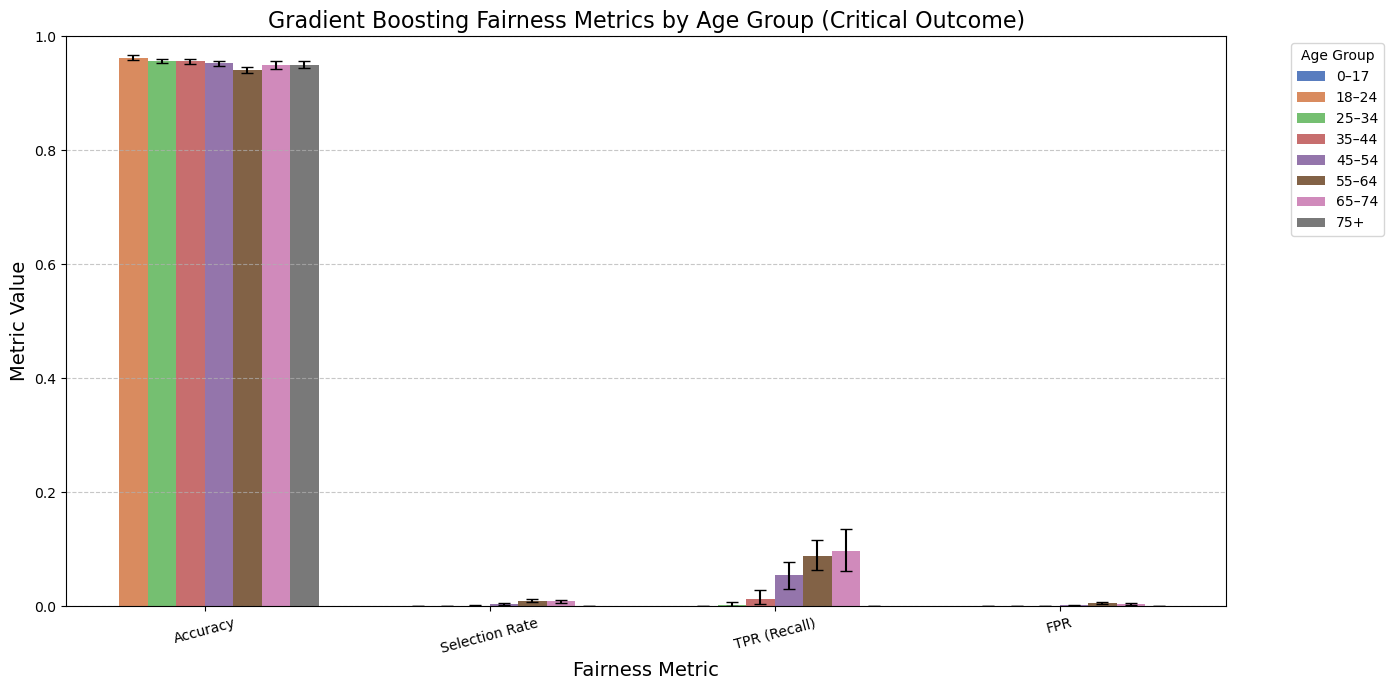

In [73]:
df_gb_age_plot = []

for row in group_metrics: 
    group = row['Age Group']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_gb_age_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_gb_age_plot = pd.DataFrame(df_gb_age_plot)

plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_gb_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_gb_age_plot['Metric'].unique()
group_list = df_gb_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_gb_age_plot[df_gb_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width / 2 + j * group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('Gradient Boosting Fairness Metrics by Age Group (Critical Outcome)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [74]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class MLP(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [79]:
from tensorflow.keras import metrics, optimizers

mlp = MLP()
mlp.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=[
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.AUC(name='auc'),
        metrics.AUC(name='auprc', curve='PR'),
        metrics.TruePositives(name='tp'),
        metrics.TrueNegatives(name='tn'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)

start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('72h_ed_revisit_mlp.keras')

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9424 - auc: 0.5809 - auprc: 0.0850 - loss: 0.3912 - precision: 0.2294 - recall: 0.0561 - tn: 89055.4844 - tp: 206.6337
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9549 - auc: 0.6244 - auprc: 0.1196 - loss: 0.1832 - precision: 0.4864 - recall: 0.0408 - tn: 89575.4297 - tp: 176.1065
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9540 - auc: 0.6464 - auprc: 0.1353 - loss: 0.1790 - precision: 0.4693 - recall: 0.0397 - tn: 89542.2500 - tp: 162.6571
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9547 - auc: 0.6580 - auprc: 0.1365 - loss: 0.1755 - precision: 0.5119 - recall: 0.0334 - tn: 89623.5938 - tp: 143.7210
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9553 - auc: 0.6509 - auprc: 0.1411 - loss: 0.1743 - precision: 0.5389 - recall: 0.0332 - tn: 89634.8906 - tp: 141.5857
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9550 - au

In [78]:
# class MLP(tf.keras.Model):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.dense_1 = Dense(128, activation='relu')
#         self.dense_2 = Dense(64, activation='relu')
#         self.classifier = Dense(1, activation='sigmoid')

#     def call(self, x):
#         x = self.dense_1(x)
#         x = self.dense_2(x)
#         return self.classifier(x)

In [77]:
# skip this cell if not retraining
# mlp = MLP()
# mlp.compile(loss='binary_crossentropy', 
#               optimizer=optimizers.Adam(learning_rate=0.001), 
#               metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
#                        'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
# start = time.time()
# mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
# runtime = time.time() - start
# print('Training time:', runtime, 'seconds')
# mlp.save('72h_ed_revisit_mlp')

MLP:
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step
AUC: 0.6874444799003413
AUPRC: 0.16747291619812266
Sensitivity: 0.5923250564334086
Specificity: 0.6714949928469242
Score thresold: 0.034838717
2.5 97.5


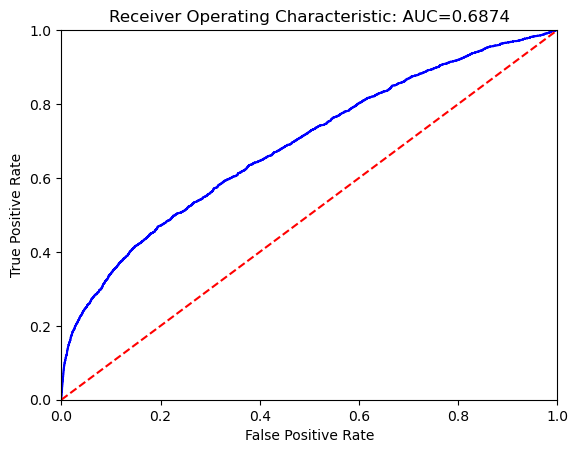

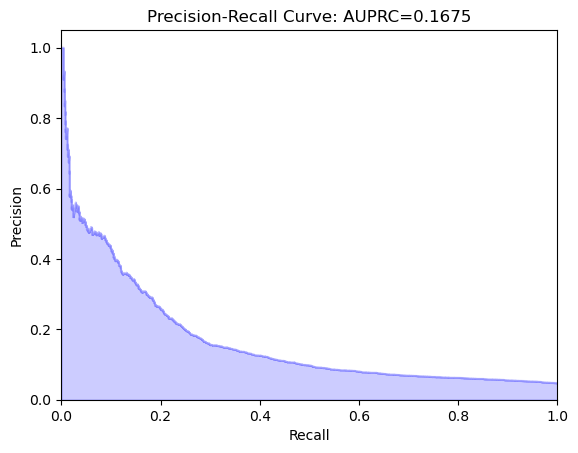

In [80]:
print("MLP:")
#mlp = load_model('72h_ed_revisit_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [81]:
def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_boot=1000, alpha=0.05, random_seed=42):
    np.random.seed(random_seed)
    values = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if sensitive_features is not None:
        sensitive_features = np.array(sensitive_features)

    n = len(y_true)
    for _ in range(n_boot):
        idx = np.random.choice(n, size=n, replace=True)
        y_true_boot = y_true[idx]
        y_pred_boot = y_pred[idx]
        if sensitive_features is not None:
            sf_boot = sensitive_features[idx]
            val = metric_func(y_true_boot, y_pred_boot, sensitive_features=sf_boot)
        else:
            val = metric_func(y_true_boot, y_pred_boot)
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

In [82]:
import numpy as np
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)

probs = mlp.predict(X_test.astype(np.float32))
if probs.shape[1] == 1:
    probs = probs[:, 0]
y_pred = (probs >= 0.5).astype(int)

gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)

metrics_summary = {
    "Accuracy": (acc_mean, acc_ci),
    "Demographic Parity": (dpd_mean, dpd_ci),
    "Equal Opportunity": (eopp_mean, eopp_ci),
    "Equalized Odds": (eod_mean, eod_ci)
}

print("\n=== MLP - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===")
for name, (mean, (ci_low, ci_high)) in metrics_summary.items():
    print(f"{name:<22} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")


1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step

=== MLP - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===
Accuracy               Mean = 0.953, CI = (0.951, 0.955)
Demographic Parity     Mean = 0.007, CI = (0.006, 0.009)
Equal Opportunity      Mean = 0.060, CI = (0.044, 0.076)
Equalized Odds         Mean = 0.060, CI = (0.044, 0.076)


In [83]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

probs = mlp.predict(X_test.astype(np.float32))
if probs.shape[1] == 1:
    probs = probs[:, 0]
y_pred = (probs >= 0.5).astype(int)

gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== MLP Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")


1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step

=== MLP Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.960, CI = (0.958, 0.962)
Selection Rate   Mean = 0.001, CI = (0.001, 0.001)
TPR (Recall)     Mean = 0.013, CI = (0.007, 0.021)
FPR              Mean = 0.000, CI = (0.000, 0.001)

Male:
Accuracy         Mean = 0.943, CI = (0.940, 0.947)
Selection Rate   Mean = 0.008, CI = (0.007, 0.009)
TPR (Recall)     Mean = 0.073, CI = (0.059, 0.089)
FPR              Mean = 0.004, CI = (0.003, 0.005)


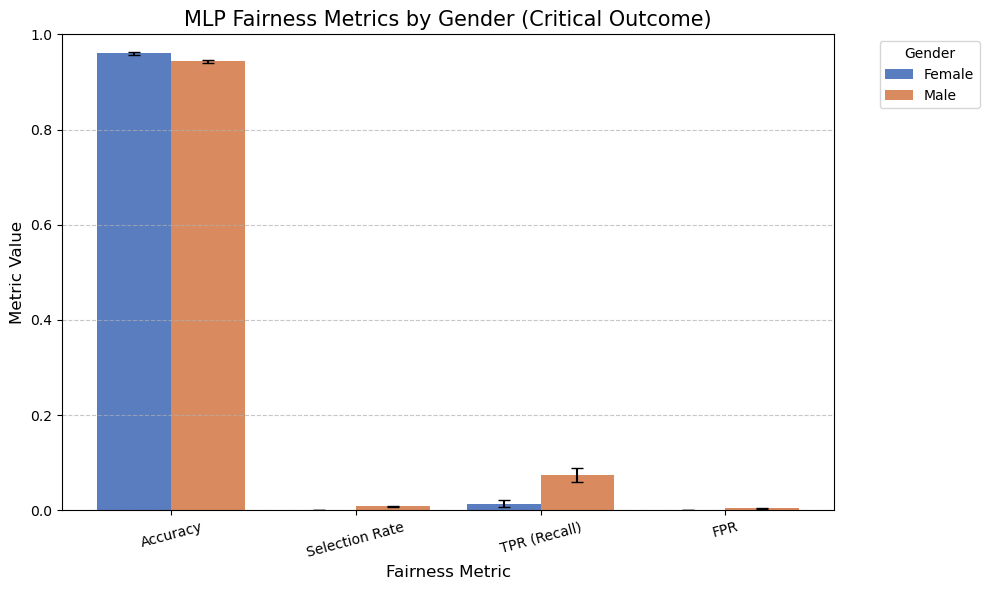

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_mlp_gender_plot = []

for group, metric_dict in metrics.items(): 
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_mlp_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_mlp_gender_plot = pd.DataFrame(df_mlp_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_mlp_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_mlp_gender_plot['Metric'].unique()
group_list = df_mlp_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_mlp_gender_plot[df_mlp_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('MLP Fairness Metrics by Gender (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [85]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = mlp.predict(X_test.astype(np.float32))
if probs.shape[1] == 1:
    probs = probs[:, 0]
y_pred = (probs >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']
valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask]

ethnicity_grouped = ethnicity_clean.str.upper()

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

print("\n=== MLP - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")


1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step

=== MLP - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===
Accuracy:              Mean = 0.908, CI = (0.903, 0.912)
Demographic Parity:    Mean = 0.016, CI = (0.013, 0.019)
Equal Opportunity:     Mean = 0.089, CI = (0.065, 0.116)
Equalized Odds:        Mean = 0.089, CI = (0.065, 0.116)


In [86]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

probs = mlp.predict(X_test.astype(np.float32))
if probs.shape[1] == 1:
    probs = probs[:, 0]
y_pred = (probs >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']
valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

ethnicity_metrics = []

for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== MLP - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
for row in ethnicity_metrics:
    print(f"\n Ethnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")


1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step

=== MLP - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===

 Ethnicity: White
Accuracy          Mean = 0.899, CI = (0.893, 0.905)
Selection Rate    Mean = 0.012, CI = (0.010, 0.015)
TPR (Recall)      Mean = 0.060, CI = (0.043, 0.077)
FPR               Mean = 0.007, CI = (0.005, 0.009)

 Ethnicity: Black or African American
Accuracy          Mean = 0.913, CI = (0.906, 0.921)
Selection Rate    Mean = 0.016, CI = (0.012, 0.019)
TPR (Recall)      Mean = 0.088, CI = (0.061, 0.114)
FPR               Mean = 0.009, CI = (0.006, 0.012)

 Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.924, CI = (0.912, 0.936)
Selection Rate    Mean = 0.005, CI = (0.003, 0.009)
TPR (Recall)      Mean = 0.057, CI = (0.025, 0.096)
FPR               Mean = 0.001, CI = (0.000, 0.003)

 Ethnicity: Asian
Accuracy          Mean = 0.917, CI = (0.887, 0.943)
Selection Rate    Mean = 0.000, CI = (0.000, 0.000)
TPR (Recall)      Mean = 0.000, CI = (0.000, 

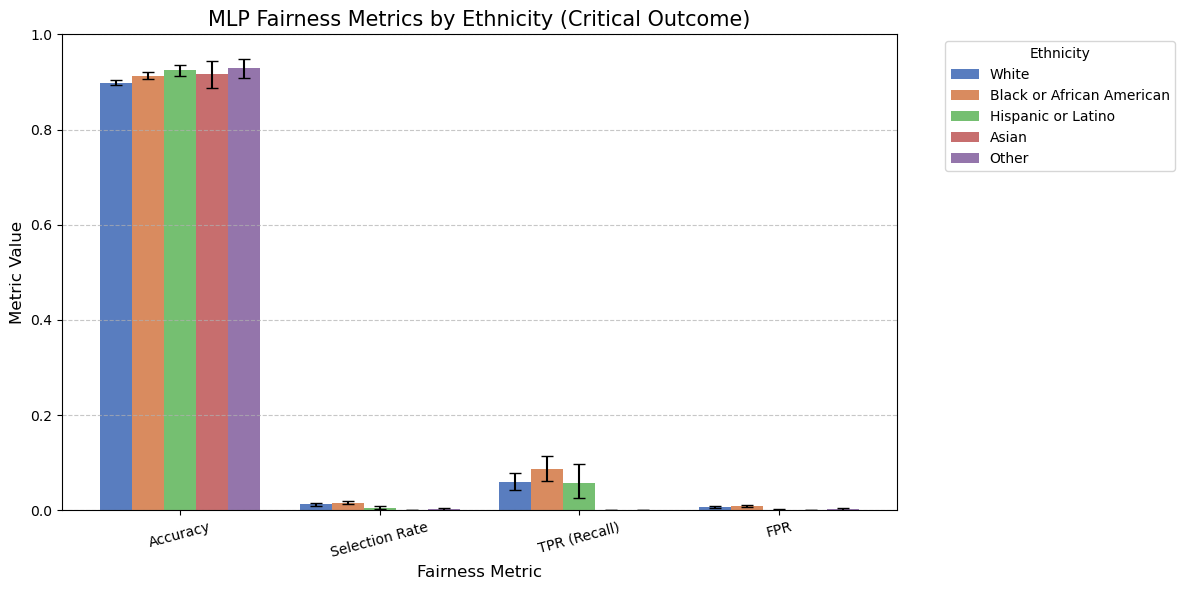

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_mlp_ethnicity_plot = []

for row in ethnicity_metrics:
    group = row['Ethnicity']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']: 
        mean, (ci_low, ci_high) = row[metric_name]
        df_mlp_ethnicity_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_mlp_ethnicity_plot = pd.DataFrame(df_mlp_ethnicity_plot)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_mlp_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_mlp_ethnicity_plot['Metric'].unique()
group_list = df_mlp_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_mlp_ethnicity_plot[df_mlp_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('MLP Fairness Metrics by Ethnicity (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [88]:
probs = mlp.predict(X_test.astype(np.float32))
if probs.shape[1] == 1:
    probs = probs[:, 0]
y_pred = (probs >= 0.5).astype(int)


age_raw = X_test['age']
valid_mask = age_raw.notna()
age_clean = age_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)

print("\n=== MLP - Bootstrapped Fairness Metrics by Age for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")


1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step

=== MLP - Bootstrapped Fairness Metrics by Age for Critical Outcome ===
Accuracy:              Mean = 0.953, CI = (0.951, 0.955)
Demographic Parity:    Mean = 0.035, CI = (0.025, 0.050)
Equal Opportunity:     Mean = 0.330, CI = (0.232, 0.462)
Equalized Odds:        Mean = 0.330, CI = (0.232, 0.462)


In [89]:
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)

valid_mask = age_grouped.notna()
y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

group_metrics = []

for group in age_labels:
    group_mask = (age_grouped_clean == group)
    if group_mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, group_mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, group_mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, group_mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, group_mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== MLP - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== MLP - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===

Age Group: 0–17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18–24
Accuracy          Mean = 0.962, CI = (0.958, 0.967)
Selection Rate    Mean = 0.000, CI = (0.000, 0.000)
TPR (Recall)      Mean = 0.000, CI = (0.000, 0.000)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Age Group: 25–34
Accuracy          Mean = 0.957, CI = (0.953, 0.961)
Selection Rate    Mean = 0.000, CI = (0.000, 0.001)
TPR (Recall)      Mean = 0.010, CI = (0.002, 0.020)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Age Group: 35–44
Accuracy          Mean = 0.956, CI = (0.951, 0.960)
Selection Rate    Mean = 0.001, CI = (0.001, 0.002)
TPR (Recall)      Mean = 0.013, CI = (0.003, 0.028)
FPR               Mean = 0.001, CI = (0.000, 0.002)

Age Group: 45–54
Accuracy          Mean = 0.951, CI = (0.947, 0.956)
Selec

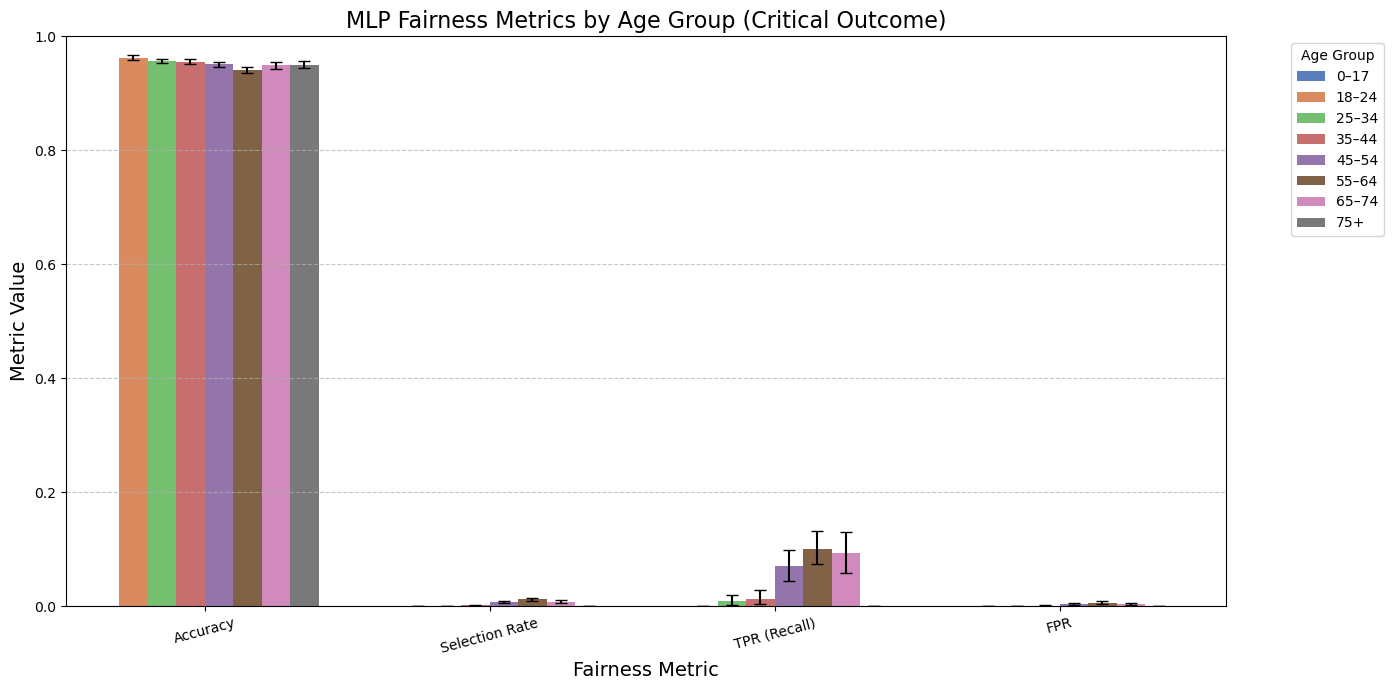

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_mlp_age_plot = []

for row in group_metrics:
    group = row['Age Group']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_mlp_age_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_mlp_age_plot = pd.DataFrame(df_mlp_age_plot)

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_mlp_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_mlp_age_plot['Metric'].unique()
group_list = df_mlp_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_mlp_age_plot[df_mlp_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width / 2 + j * group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('MLP Fairness Metrics by Age Group (Critical Outcome)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [12]:
from keras.saving import register_keras_serializable

@register_keras_serializable()
class LSTM_MLP(tf.keras.Model):
    def __init__(self):
        super(LSTM_MLP, self).__init__()
        self.dense_1 = Dense(96, activation='relu')
        self.lstm = LSTM(32)
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x1, x2 = x
        x = self.dense_1(x1)
        lstm_output = self.lstm(x2)
        x = concatenate([x, lstm_output])
        x = self.dense_2(x)
        return self.classifier(x)


In [171]:
print(outcome in df_train.columns)
print(df_train.columns)


False
Index(['index', 'subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime',
       'anchor_age', 'gender', 'anchor_year', 'dod',
       ...
       'ed_resprate_y', 'ed_o2sat_y', 'ed_sbp_y', 'ed_dbp_y', 'ed_heartrate',
       'ed_resprate', 'ed_o2sat', 'ed_sbp', 'ed_dbp', 'ed_temperature'],
      dtype='object', length=144)


In [172]:
print([col for col in df_train.columns if 'outcome' in col.lower()])


['outcome_inhospital_mortality', 'outcome_icu_transfer_12h', 'outcome_hospitalization', 'outcome_critical', 'outcome_ed_revisit_3d']


In [13]:
import os
import pandas as pd

raw_path = os.path.expanduser('~/Desktop/MIMIC/mimic4ed-benchmark/data/ed/vitalsign.csv')

df = pd.read_csv(raw_path, parse_dates=['charttime'])

vital_cols = ['heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'temperature']
group_cols = ['subject_id', 'stay_id']

missing_cols = [col for col in (group_cols + ['charttime'] + vital_cols) if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in vitalsign.csv: {missing_cols}")

df.set_index('charttime', inplace=True)
df_resampled = (
    df
    .groupby(group_cols)[vital_cols]
    .resample('1H')
    .mean()
    .reset_index()
)

output_path = os.path.expanduser('~/Desktop/MIMIC/mimic4ed-benchmark/data/ed_vitalsign_1H_resampled.csv')
df_resampled.to_csv(output_path, index=False)

print("Resampled file saved to:", output_path)


Resampled file saved to: /home/rkc7gr/Desktop/MIMIC/mimic4ed-benchmark/data/ed_vitalsign_1H_resampled.csv


In [13]:
def get_lstm_data_gen(df_train, df_test, df_vitalsign, variable, outcome, time_steps=12):
    import numpy as np
    import tensorflow as tf

    def build_static(df):
        X = df[variable].fillna(0).astype(np.float32)
        return X.to_numpy()

    def build_labels(df):
        y = df[outcome].astype(np.float32)
        return y.to_numpy()


    def build_sequence(df_ids, df_vitalsign, time_steps=12):
        vital_cols = ['ed_heartrate', 'ed_resprate', 'ed_o2sat', 'ed_sbp', 'ed_dbp', 'ed_temperature']
        sequences = []
        for pid in df_ids:
            vitals = df_vitalsign[df_vitalsign['subject_id'] == pid].sort_values('charttime')
            vitals = vitals[vital_cols].fillna(0).to_numpy().astype(np.float32)

            if vitals.shape[0] >= time_steps:
                seq = vitals[:time_steps]
            else:
                pad = np.zeros((time_steps - vitals.shape[0], len(vital_cols)), dtype=np.float32)
                seq = np.vstack([vitals, pad])
            sequences.append(seq)

        return np.stack(sequences)

    X_static_train = build_static(df_train)
    X_static_test = build_static(df_test)
    y_train = build_labels(df_train)
    y_test = build_labels(df_test)
    X_seq_train = build_sequence(df_train['subject_id'], df_vitalsign, time_steps)
    X_seq_test = build_sequence(df_test['subject_id'], df_vitalsign, time_steps)

    def make_dataset(X_static, X_seq, y):
        def gen():
            for i in range(len(y)):
                yield (X_static[i], X_seq[i]), y[i]

        output_signature = (
            (
                tf.TensorSpec(shape=(X_static.shape[1],), dtype=tf.float32),
                tf.TensorSpec(shape=(X_seq.shape[1], X_seq.shape[2]), dtype=tf.float32)
            ),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )

        return tf.data.Dataset.from_generator(gen, output_signature=output_signature).batch(64).prefetch(tf.data.AUTOTUNE)

    return make_dataset(X_static_train, X_seq_train, y_train), make_dataset(X_static_test, X_seq_test, y_test)


In [14]:
# Convert gender to numeric: M = 1, F = 0
df_train['gender'] = df_train['gender'].map({'M': 1, 'F': 0}).astype(np.float32)
df_test['gender'] = df_test['gender'].map({'M': 1, 'F': 0}).astype(np.float32)


In [15]:
def convert_timedelta_to_minutes(df, columns):
    for col in columns:
        if df[col].dtype == 'object' and df[col].str.contains('days|:').any():
            df[col] = pd.to_timedelta(df[col], errors='coerce').dt.total_seconds() / 60  # convert to minutes
    return df

df_train = convert_timedelta_to_minutes(df_train, variable)
df_test = convert_timedelta_to_minutes(df_test, variable)


In [16]:
df_vitalsign = pd.read_csv('~/Desktop/MIMIC/mimic4ed-benchmark/data/ed_vitalsign_1H_resampled.csv', parse_dates=['charttime'])

df_vitalsign.rename(columns={
    'heartrate': 'ed_heartrate',
    'resprate': 'ed_resprate',
    'o2sat': 'ed_o2sat',
    'sbp': 'ed_sbp',
    'dbp': 'ed_dbp',
    'temperature': 'ed_temperature'
}, inplace=True)


In [17]:
train_data_gen, test_data_gen = get_lstm_data_gen(df_train, df_test, df_vitalsign, variable, outcome)

2025-05-05 10:45:04.393985: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [18]:
from keras.saving import register_keras_serializable
from tensorflow.keras.layers import Dense, LSTM, concatenate
from tensorflow.keras import Model

@register_keras_serializable()
class LSTM_MLP(Model):
    def __init__(self, dense1_units=96, lstm_units=32, dense2_units=64, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = Dense(dense1_units, activation='relu')
        self.lstm = LSTM(lstm_units)
        self.dense_2 = Dense(dense2_units, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x1, x2 = x
        x = self.dense_1(x1)
        lstm_output = self.lstm(x2)
        x = concatenate([x, lstm_output])
        x = self.dense_2(x)
        return self.classifier(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "dense1_units": self.dense_1.units,
            "lstm_units": self.lstm.units,
            "dense2_units": self.dense_2.units,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [19]:
from tensorflow.keras import optimizers, metrics
import time

lstm = LSTM_MLP()
lstm.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(learning_rate=0.001), 
    metrics=[
        'accuracy',
        metrics.AUC(name='auc', curve='ROC'),
        metrics.AUC(name='auprc', curve='PR'),
        metrics.TruePositives(),
        metrics.TrueNegatives(),
        metrics.Precision(),
        metrics.Recall()
    ]
)

start = time.time()
lstm.fit(train_data_gen, epochs=20)  # ❗️remove batch_size
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

lstm.save('72h_ed_revisit_lstm.keras')  # ❗️Use `.keras` extension per Keras 3 requirement


Epoch 1/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.9441 - auc: 0.6524 - auprc: 0.0971 - loss: 0.3512 - precision: 0.2323 - recall: 0.0442 - true_negatives: 89091.6953 - true_positives: 152.3874
Epoch 2/20
   5/2929 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9389 - auc: 0.5526 - auprc: 0.1893 - loss: 0.2374 - precision: 0.2000 - recall: 0.0111 - true_negatives: 180.8000 - true_positives: 0.2000            

2025-05-05 10:45:47.483138: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/rkc7gr/.local/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2929/2929 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9551 - auc: 0.7288 - auprc: 0.1525 - loss: 0.1666 - precision: 0.5515 - recall: 0.0338 - true_negatives: 89431.0312 - true_positives: 133.1754
Epoch 3/20
   9/2929 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9445 - auc: 0.5608 - auprc: 0.1698 - loss: 0.2282 - precision: 0.5556 - recall: 0.0248 - true_negatives: 303.1111 - true_positives: 0.5556           

2025-05-05 10:46:27.576494: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2929/2929 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9553 - auc: 0.7332 - auprc: 0.1584 - loss: 0.1650 - precision: 0.5858 - recall: 0.0358 - true_negatives: 89441.6484 - true_positives: 138.9584
Epoch 4/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9553 - auc: 0.7394 - auprc: 0.1648 - loss: 0.1638 - precision: 0.5752 - recall: 0.0326 - true_negatives: 89452.9141 - true_positives: 121.3509
Epoch 5/20
   9/2929 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9432 - auc: 0.5602 - auprc: 0.1998 - loss: 0.2377 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_negatives: 303.1111 - true_positives: 0.0000e+00

2025-05-05 10:47:46.248189: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2929/2929 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9553 - auc: 0.7402 - auprc: 0.1676 - loss: 0.1635 - precision: 0.5801 - recall: 0.0341 - true_negatives: 89452.1641 - true_positives: 123.7024
Epoch 6/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9552 - auc: 0.7416 - auprc: 0.1670 - loss: 0.1633 - precision: 0.5923 - recall: 0.0231 - true_negatives: 89482.3516 - true_positives: 84.5150
Epoch 7/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9553 - auc: 0.7423 - auprc: 0.1680 - loss: 0.1633 - precision: 0.5980 - recall: 0.0283 - true_negatives: 89469.1641 - true_positives: 105.9628
Epoch 8/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9554 - auc: 0.7435 - auprc: 0.1694 - loss: 0.1629 - precision: 0.6130 - recall: 0.0306 - true_negatives: 89471.3984 - true_positives: 110.4826
Epoch 9/20
   9/2929 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9432 - auc: 0.5606 - auprc: 0.2002 - loss: 0.2353 - precision: 0.0000e+00 - recall: 0.0000

2025-05-05 10:50:21.543678: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2929/2929 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9553 - auc: 0.7451 - auprc: 0.1705 - loss: 0.1628 - precision: 0.5747 - recall: 0.0319 - true_negatives: 89454.8359 - true_positives: 116.3857
Epoch 12/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.9554 - auc: 0.7445 - auprc: 0.1710 - loss: 0.1627 - precision: 0.6131 - recall: 0.0292 - true_negatives: 89471.1562 - true_positives: 109.8911
Epoch 13/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9554 - auc: 0.7478 - auprc: 0.1730 - loss: 0.1623 - precision: 0.6102 - recall: 0.0338 - true_negatives: 89459.5781 - true_positives: 123.8034
Epoch 14/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9554 - auc: 0.7479 - auprc: 0.1734 - loss: 0.1623 - precision: 0.6117 - recall: 0.0301 - true_negatives: 89468.1328 - true_positives: 113.2393
Epoch 15/20
 963/2929 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9562 - auc: 0.7433 - auprc: 0.1817 - loss: 0.1617 - precision: 0.6723 - recall: 0.040

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



LSTM:
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
AUC: 0.7637825178342489
AUPRC: 0.18405755705133675
Sensitivity: 0.6862302483069977
Specificity: 0.6841693490701002
Score thresold: 0.030536307
2.5 97.5


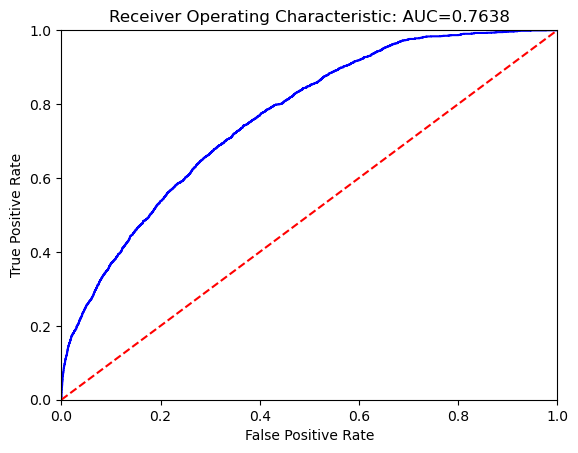

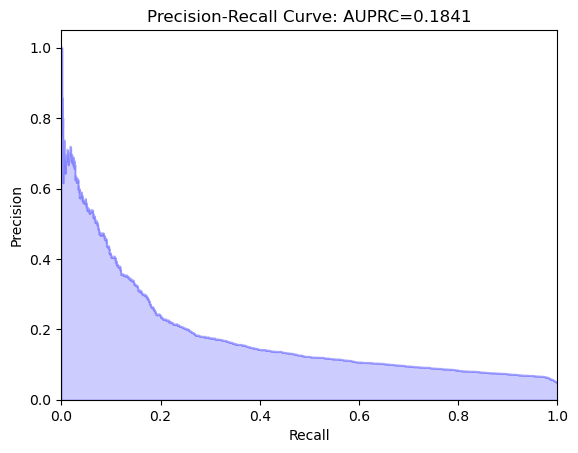

In [20]:
from keras.models import load_model

print("LSTM:")
lstm = load_model('72h_ed_revisit_lstm.keras', custom_objects={'LSTM_MLP': LSTM_MLP})

# Extract y_test from the generator
_, y_test = zip(*[(x, y) for x, y in test_data_gen.unbatch()])
y_test = np.array(y_test)

# Predict
probs = lstm.predict(test_data_gen)

# Evaluate
result = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)
results = ["LSTM"]
results.extend(result)
results.append(runtime)
result_list.append(results)


In [21]:
import numpy as np

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true_group = np.array(y_true)[group_mask]
    y_pred_group = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        if len(y_true_group) == 0:
            continue  # avoid empty group entirely

        idx = np.random.choice(len(y_true_group), size=len(y_true_group), replace=True)
        y_true_sample = y_true_group[idx]
        y_pred_sample = y_pred_group[idx]

        if len(y_pred_sample) == 0 or np.all(pd.isnull(y_pred_sample)):
            continue  # skip if the sampled prediction is empty

        try:
            val = metric_func(y_true_sample, y_pred_sample)
            values.append(val)
        except Exception:
            continue

    if len(values) == 0:
        return np.nan, (np.nan, np.nan)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)



In [38]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

# Get binary predictions from LSTM output
y_pred_lstm = (probs >= 0.5).astype(int).flatten()

# Use numeric gender (0 = F, 1 = M)
gender_raw = df_test['gender']
valid_mask = gender_raw.isin([0, 1])

# Filter arrays
y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred_lstm[valid_mask]
gender_grouped = gender_raw[valid_mask].astype(int)  # Ensure it's integer type

# Compute metrics
acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)

# Print results
print("\n=== LSTM - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")




=== LSTM - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===
Accuracy:              Mean = 0.953, CI = (0.951, 0.955)
Demographic Parity:    Mean = 0.007, CI = (0.006, 0.009)
Equal Opportunity:     Mean = 0.060, CI = (0.045, 0.076)
Equalized Odds:        Mean = 0.060, CI = (0.045, 0.076)


In [45]:
print(df_test['gender'].unique())
print(df_test['gender'].isna().sum())


[1. 0.]
0


In [46]:
print("Valid samples after gender filtering:", valid_mask.sum())


Valid samples after gender filtering: 46951


In [47]:
print("Female samples:", (gender_grouped == 0).sum())
print("Male samples:", (gender_grouped == 1).sum())


Female samples: 0
Male samples: 0


In [48]:
gender_grouped = gender_clean.astype(int)


In [49]:
female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values


In [51]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true_group = np.array(y_true)[group_mask]
    y_pred_group = np.array(y_pred)[group_mask]

    if len(y_true_group) == 0:
        return np.nan, (np.nan, np.nan)

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true_group), size=len(y_true_group), replace=True)
        try:
            val = metric_func(y_true_group[idx], y_pred_group[idx])
            values.append(val)
        except Exception:
            continue

    if len(values) == 0:
        return np.nan, (np.nan, np.nan)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

y_pred_lstm = (probs >= 0.5).astype(int).flatten()

gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (~gender_raw.astype(str).str.lower().eq('unknown'))
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred_lstm[valid_mask]
gender_clean = gender_raw[valid_mask]

gender_grouped = gender_clean.astype(int)

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

metrics = {}
for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== LSTM Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== LSTM Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.960, CI = (0.958, 0.962)
Selection Rate   Mean = 0.001, CI = (0.000, 0.001)
TPR (Recall)     Mean = 0.008, CI = (0.004, 0.014)
FPR              Mean = 0.000, CI = (0.000, 0.000)

Male:
Accuracy         Mean = 0.943, CI = (0.940, 0.946)
Selection Rate   Mean = 0.008, CI = (0.007, 0.009)
TPR (Recall)     Mean = 0.068, CI = (0.054, 0.083)
FPR              Mean = 0.004, CI = (0.003, 0.005)


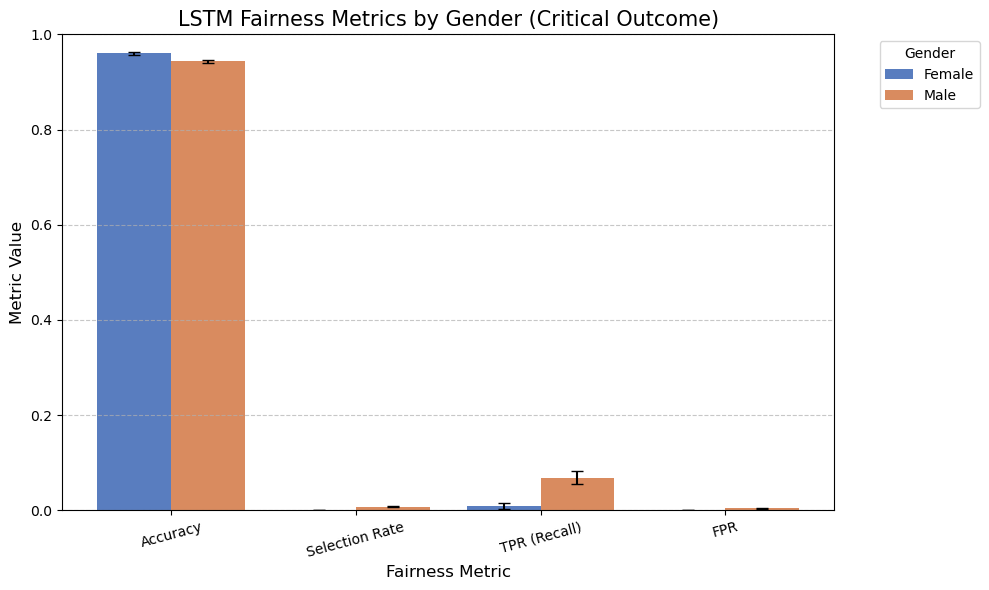

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_lstm_gender_plot = []

for group, metric_dict in metrics.items():
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_lstm_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_lstm_gender_plot = pd.DataFrame(df_lstm_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_lstm_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_lstm_gender_plot['Metric'].unique()
group_list = df_lstm_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_lstm_gender_plot[df_lstm_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('LSTM Fairness Metrics by Gender (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [53]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

y_pred_lstm = (probs >= 0.5).astype(int).flatten()

ethnicity_raw = df_test['ethnicity']

valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw.astype(str) != '') &
    (~ethnicity_raw.astype(str).str.lower().isin(['unknown', 'unable to obtain']))
)

y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred_lstm[valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask].astype(str).str.upper()

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_clean
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_clean
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_clean
)

print("\n=== LSTM - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== LSTM - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===
Accuracy:              Mean = 0.908, CI = (0.903, 0.912)
Demographic Parity:    Mean = 0.016, CI = (0.013, 0.020)
Equal Opportunity:     Mean = 0.088, CI = (0.062, 0.116)
Equalized Odds:        Mean = 0.088, CI = (0.062, 0.116)


In [54]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    if len(y_true) == 0:
        return np.nan, (np.nan, np.nan)

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        try:
            val = metric_func(y_true[idx], y_pred[idx])
            values.append(val)
        except Exception:
            continue

    if len(values) == 0:
        return np.nan, (np.nan, np.nan)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

y_pred_lstm = (probs >= 0.5).astype(int).flatten()

ethnicity_raw = df_test['ethnicity']
valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw.astype(str) != '') &
    (~ethnicity_raw.astype(str).str.lower().eq('unknown')) &
    (~ethnicity_raw.astype(str).str.lower().eq('unable to obtain'))
)

ethnicity_clean = ethnicity_raw[valid_mask].astype(str).str.lower()
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred_lstm[valid_mask]

ethnicity_grouped = ethnicity_clean.map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

ethnicity_metrics = []

for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== LSTM - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
for row in ethnicity_metrics:
    print(f"\n Ethnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== LSTM - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===

 Ethnicity: White
Accuracy          Mean = 0.899, CI = (0.893, 0.906)
Selection Rate    Mean = 0.010, CI = (0.008, 0.012)
TPR (Recall)      Mean = 0.053, CI = (0.039, 0.068)
FPR               Mean = 0.005, CI = (0.004, 0.007)

 Ethnicity: Black or African American
Accuracy          Mean = 0.912, CI = (0.905, 0.920)
Selection Rate    Mean = 0.016, CI = (0.012, 0.020)
TPR (Recall)      Mean = 0.087, CI = (0.061, 0.116)
FPR               Mean = 0.009, CI = (0.007, 0.012)

 Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.922, CI = (0.910, 0.933)
Selection Rate    Mean = 0.003, CI = (0.001, 0.006)
TPR (Recall)      Mean = 0.025, CI = (0.006, 0.053)
FPR               Mean = 0.001, CI = (0.000, 0.003)

 Ethnicity: Asian
Accuracy          Mean = 0.917, CI = (0.887, 0.943)
Selection Rate    Mean = 0.000, CI = (0.000, 0.000)
TPR (Recall)      Mean = 0.000, CI = (0.000, 0.000)
FPR               Mean = 0.000, CI = 

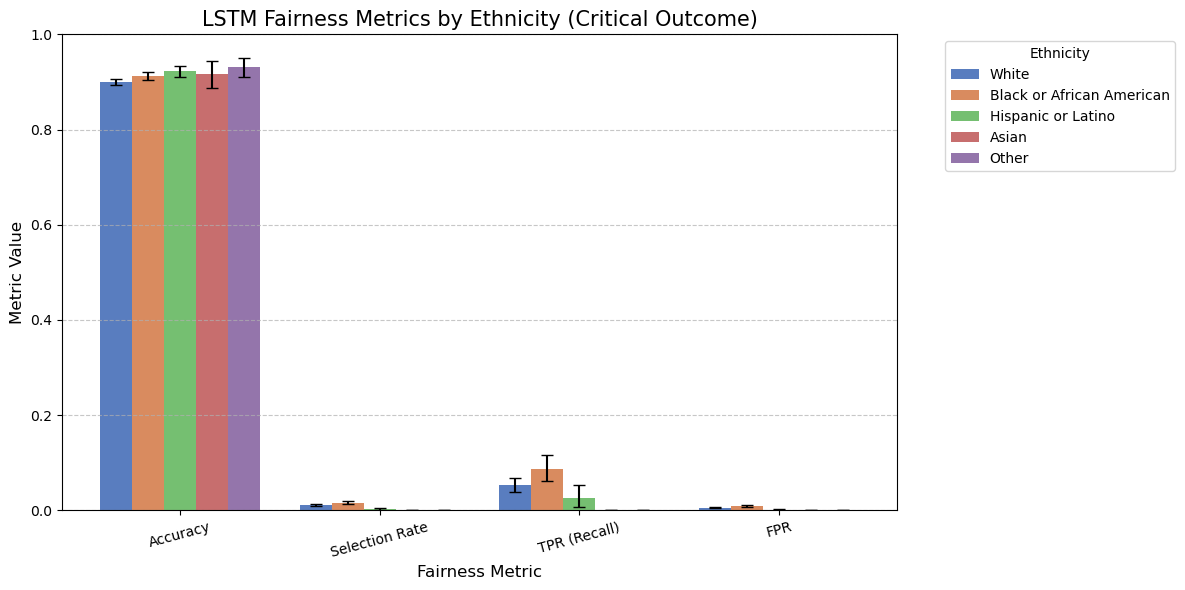

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_lstm_ethnicity_plot = []

for row in ethnicity_metrics:
    group = row['Ethnicity']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']: 
        mean, (ci_low, ci_high) = row[metric_name]
        df_lstm_ethnicity_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_lstm_ethnicity_plot = pd.DataFrame(df_lstm_ethnicity_plot)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_lstm_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_lstm_ethnicity_plot['Metric'].unique()
group_list = df_lstm_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_lstm_ethnicity_plot[df_lstm_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('LSTM Fairness Metrics by Ethnicity (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [56]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

y_pred = (probs >= 0.5).astype(int).flatten()

age_raw = df_test['age']
valid_mask = age_raw.notna()

age_clean = age_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=age_clean
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=age_clean
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=age_clean
)

print("\n=== LSTM - Bootstrapped Fairness Metrics by Age for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== LSTM - Bootstrapped Fairness Metrics by Age for Critical Outcome ===
Accuracy:              Mean = 0.953, CI = (0.951, 0.955)
Demographic Parity:    Mean = 0.031, CI = (0.023, 0.043)
Equal Opportunity:     Mean = 0.353, CI = (0.250, 0.515)
Equalized Odds:        Mean = 0.353, CI = (0.250, 0.515)


In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    metrics = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metric = metric_func(y_true[idx], y_pred[idx])
        metrics.append(metric)

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)

y_pred = (probs >= 0.5).astype(int).flatten()

age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
age_grouped = pd.cut(df_test['age'], bins=age_bins, labels=age_labels, right=True)

valid_mask = age_grouped.notna()
y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

group_metrics = []

for group in age_labels:
    group_mask = (age_grouped_clean == group)

    if group_mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, group_mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, group_mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, group_mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, group_mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== LSTM - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== LSTM - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===

Age Group: 0–17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18–24
Accuracy          Mean = 0.962, CI = (0.958, 0.967)
Selection Rate    Mean = 0.000, CI = (0.000, 0.000)
TPR (Recall)      Mean = 0.000, CI = (0.000, 0.000)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Age Group: 25–34
Accuracy          Mean = 0.956, CI = (0.952, 0.960)
Selection Rate    Mean = 0.000, CI = (0.000, 0.000)
TPR (Recall)      Mean = 0.000, CI = (0.000, 0.000)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Age Group: 35–44
Accuracy          Mean = 0.956, CI = (0.951, 0.961)
Selection Rate    Mean = 0.001, CI = (0.000, 0.002)
TPR (Recall)      Mean = 0.010, CI = (0.000, 0.023)
FPR               Mean = 0.000, CI = (0.000, 0.001)

Age Group: 45–54
Accuracy          Mean = 0.953, CI = (0.948, 0.957)
Sele

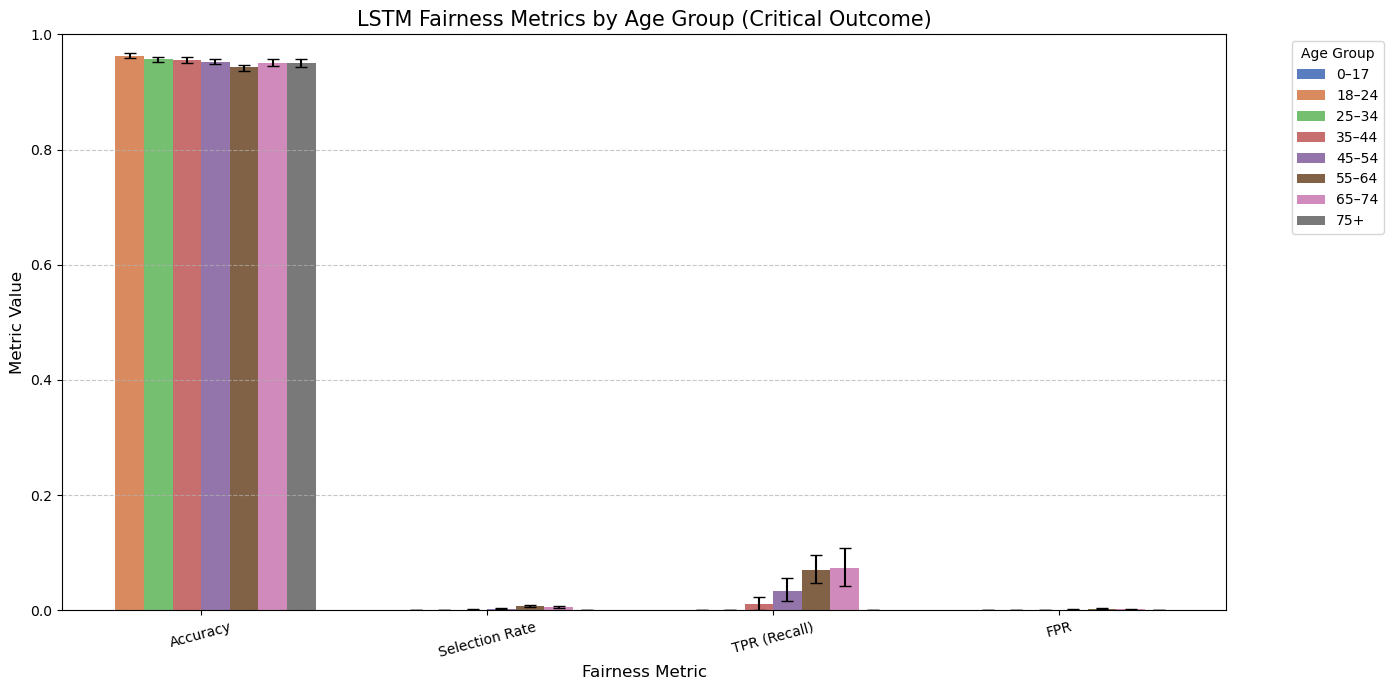

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_lstm_age_plot = []

for row in group_metrics:
    group = row['Age Group']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']: 
        mean, (ci_low, ci_high) = row[metric_name]
        df_lstm_age_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_lstm_age_plot = pd.DataFrame(df_lstm_age_plot)

plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_lstm_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_lstm_age_plot['Metric'].unique()
group_list = df_lstm_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_lstm_age_plot[df_lstm_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width / 2 + j * group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('LSTM Fairness Metrics by Age Group (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [23]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


In [24]:
## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore)
AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_ED_revisit.csv')))
df_test["AutoScore"] = AutoScore_pred["pred_score"]

AutoScore
AUC: 0.6725817495520624
AUPRC: 0.11388656627666868
Sensitivity: 0.6209912536443148
Specificity: 0.6277184925030392
Score thresold: 27
2.5 97.5


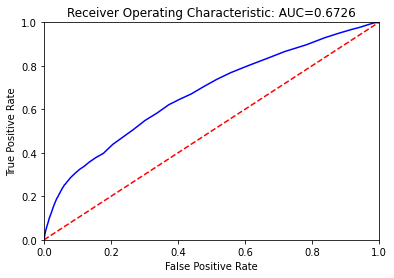

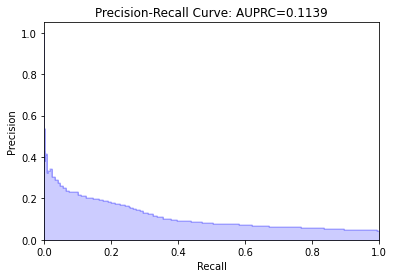

In [25]:
get_score_performance("AutoScore", random_seed=random_seed) 

In [26]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model
from embedding import *

In [27]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


Model: "embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 icd_input (InputLayer)         [(None, 7930)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 7930, 1024)   8121344     ['icd_input[0][0]']              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None, 1024)        0           ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 dense_6 (Dense)                (None, 256)          262400      ['tf.math.reduce_su

INFO:tensorflow:Assets written to: embedding_revisit_v10/assets


233/233 [==============================] - 0s 2ms/step
AUC: 0.6726617333669218
AUPRC: 0.13875200915815145
Sensitivity: 0.5743440233236151
Specificity: 0.681908235400063
Score thresold: 0.002062982
2.5 97.5


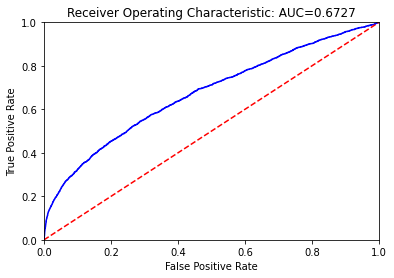

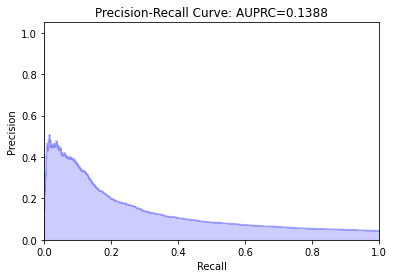

In [28]:
# To train from scratch, set load_model to None
load_model = None# "embedding_revisit_"+version 
save_model = "embedding_revisit_"+version

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1063.299 # to be updated
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [29]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task3.csv'), index=False)
formatted_result_df

Model  Threshold                AUROC                AUPRC  \
0         LR      0.041  0.683 (0.677-0.698)   0.153 (0.14-0.168)   
1         RF      0.060  0.666 (0.657-0.676)   0.15 (0.137-0.163)   
2         GB      0.038    0.7 (0.691-0.713)  0.162 (0.149-0.177)   
3        MLP      0.027   0.696 (0.687-0.71)  0.165 (0.151-0.178)   
4       LSTM      0.034  0.694 (0.682-0.706)   0.15 (0.139-0.163)   
5  AutoScore     27.000  0.673 (0.665-0.684)  0.114 (0.107-0.124)   
6    Med2Vec      0.002  0.673 (0.661-0.684)  0.139 (0.128-0.153)   

           Sensitivity          Specificity    Runtime  
0  0.627 (0.604-0.652)   0.636 (0.63-0.653)      1.675  
1   0.54 (0.531-0.605)   0.706 (0.62-0.708)     27.113  
2  0.639 (0.607-0.672)  0.642 (0.617-0.679)     29.677  
3  0.644 (0.628-0.667)  0.641 (0.631-0.648)     90.928  
4   0.63 (0.606-0.663)   0.65 (0.623-0.686)  11422.562  
5  0.621 (0.596-0.637)  0.628 (0.622-0.665)      0.000  
6  0.574 (0.562-0.621)  0.682 (0.635-0.691)    538.441

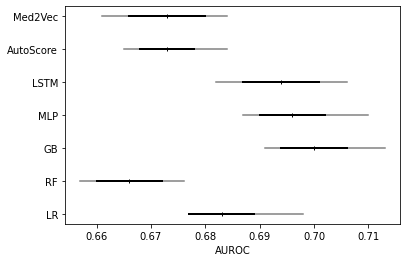

In [30]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_72h.eps', my_path = output_path) 

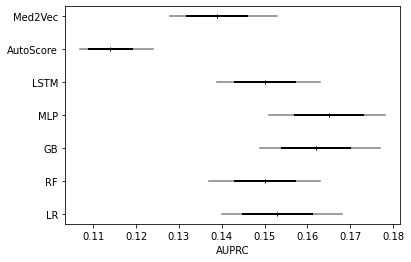

In [31]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_72h.eps', my_path = output_path)

In [32]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_72h_ed_revisit_disposition.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

Variable  Importance
0                            age    0.083975
64                        ed_los    0.083736
62                   ed_sbp_last    0.078872
63                   ed_dbp_last    0.076651
59             ed_heartrate_last    0.076166
58           ed_temperature_last    0.066873
66                    n_medrecon    0.051775
11                   triage_pain    0.043898
65                         n_med    0.039275
61                 ed_o2sat_last    0.038665
60              ed_resprate_last    0.037464
4                      n_ed_365d    0.033144
3                       n_ed_90d    0.024630
12                 triage_acuity    0.022372
7                    n_hosp_365d    0.020840
2                       n_ed_30d    0.020420
1                         gender    0.013886
6                     n_hosp_90d    0.013020
5                     n_hosp_30d    0.009717
14       chiefcom_abdominal_pain    0.008647
44                      eci_HTN2    0.006599
57                eci_Depression    0.006109
15             chiefcom_headache    0.005951
28                 cci_Pulmonary    0.005925
17            chiefcom_back_pain    0.005490
13           chiefcom_chest_pain    0.005448
54                   eci_Alcohol    0.005405
51               eci_FluidsLytes    0.005316
32                       cci_DM1    0.005198
40                eci_Arrhythmia    0.005102
55                     eci_Drugs    0.005086
49                   eci_Obesity    0.004704
45                eci_NeuroOther    0.004573
10                    n_icu_365d    0.004102
19      chiefcom_nausea_vomiting    0.004075
31                    cci_Liver1    0.004008
46               eci_Hypothyroid    0.003678
53                    eci_Anemia    0.003667
48              eci_Coagulopathy    0.003600
56                 eci_Psychoses    0.003352
36                   cci_Cancer1    0.003348
20         chiefcom_fever_chills    0.003043
50                eci_WeightLoss    0.002999
22            chiefcom_dizziness    0.002911
24                       cci_CHF    0.002909
26                    cci_Stroke    0.002906
23                        cci_MI    0.002840
43                      eci_HTN1    0.002760
33                       cci_DM2    0.002724
35                     cci_Renal    0.002681
25                       cci_PVD    0.002672
18                chiefcom_cough    0.002562
42                      eci_PHTN    0.002438
41                  eci_Valvular    0.002428
9                      n_icu_90d    0.002096
21              chiefcom_syncope    0.002033
29                 cci_Rheumatic    0.001914
30                       cci_PUD    0.001751
38                   cci_Cancer2    0.001750
39                       cci_HIV    0.001670
52                 eci_BloodLoss    0.001531
37                    cci_Liver2    0.001428
34                 cci_Paralysis    0.001395
27                  cci_Dementia    0.001342
47                  eci_Lymphoma    0.001150
8                      n_icu_30d    0.001062
16  chiefcom_shortness_of_breath    0.000244